# Case Study: Investigating Distributions in NDT7 and Cloudflare AIM Data

This code investigates and compares the distributions of data from two sources:

1. **NDT7 dataset**: Contains network performance measurements, such as latency and throughput.
2. **Cloudflare AIM dataset**: Provides performance data from Cloudflare’s network, including server response times and packet loss.

### Objective:
The primary goal is to explore the distribution of the **merged dataset** and check how the individual distributions compare with the merged one.

### Steps:
1. **Distribution Comparison**: We will visualize the distributions of key features from both datasets and the merged dataset.
2. **Merging**: Finally, we will merge the datasets and compare the overall distribution.

The analysis will help determine whether combining the datasets affects their individual distributions or if they align in meaningful ways.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [12]:
ndt7_download = pd.read_csv("data/ndt7_download_case_study.csv")
ndt7_upload = pd.read_csv("data/ndt7_upload_case_study.csv")
cf_data_mean = pd.read_csv("data/cloudflare_case_study_mean.csv")
cf_data_median = pd.read_csv("data/cloudflare_case_study_median.csv")
cf_data_90th_percentile = pd.read_csv("data/cloudflare_case_study_90th_percentile.csv")

countries = np.union1d(
    ndt7_download['country_iso'].unique(),
    cf_data_mean['country_iso'].unique()
)

common_fields = ["city", "country_iso", "test_time", "asn"]
download_study_fields = ["packet_loss_rate", "download_throughput_mbps", "download_latency_ms", "download_jitter"]
upload_study_fields = ["packet_loss_rate", "upload_throughput_mbps", "upload_latency_ms", "upload_jitter"]

download_fields_info = {
    "packet_loss_rate": {
        "title": "Packet Loss Rate",
        "measure_unit": "%"
    },
    "download_throughput_mbps": {
        "title": "Download Throughput",
        "measure_unit": "Mbps"
    },
    "download_latency_ms": {
        "title": "Download Latency",
        "measure_unit": "ms"
    },
    "download_jitter": {
        "title": "Download Jitter",
    }
}

upload_fields_info = {
    "packet_loss_rate": {
        "title": "Packet Loss Rate",
        "measure_unit": "%"
    },
    "upload_throughput_mbps": {
        "title": "Upload Throughput",
        "measure_unit": "Mbps"
    },
    "upload_latency_ms": {
        "title": "Upload Latency",
        "measure_unit": "ms"
    },
    "upload_jitter": {
        "title": "Upload Jitter",
    }
}

In [13]:
def plot_distribution_download(ndt7_download, cf_data, country_iso: str):
    legend_added = False
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))

    for i, attribute_name in enumerate(download_study_fields):
        title = f'{download_fields_info[attribute_name]["title"]} ({country_iso})'
        measure_unit = download_fields_info[attribute_name].get("measure_unit")
        x_label = f'{attribute_name} ({measure_unit})' if measure_unit else f'{attribute_name}'

        ndt7_download_measurement = ndt7_download[ndt7_download['country_iso'] == country_iso][[attribute_name]].copy().dropna()
        cf_download_measurement = cf_data[cf_data['country_iso'] == country_iso][[attribute_name]].copy().dropna()
        if country_iso not in countries:
            ndt7_download_measurement = ndt7_download[[attribute_name]].copy().dropna()
            cf_download_measurement = cf_data[[attribute_name]].copy().dropna()
        merged_data = pd.concat([ndt7_download_measurement, cf_download_measurement], ignore_index=True)


        counts_ndt7, bin_edges_ndt7 = np.histogram(
            ndt7_download_measurement[attribute_name].dropna(),
            bins=100, density=True
        )

        ndt_bin_width = bin_edges_ndt7[1] - bin_edges_ndt7[0]
        cf_num_bins = max(int((np.max(cf_download_measurement[attribute_name]) - np.min(cf_download_measurement[attribute_name])) / ndt_bin_width), 1)
        counts_cf, bin_edges_cf = np.histogram(
            cf_download_measurement[attribute_name].dropna(),
            bins=cf_num_bins, density=True
        )
        merged_num_bins = max(int((np.max(merged_data[attribute_name]) - np.min(merged_data[attribute_name])) / ndt_bin_width), 1)
        counts_merged, bin_edges_merged = np.histogram(merged_data[attribute_name], bins=merged_num_bins, density=True)

        upper_limit = np.percentile(merged_data[attribute_name].dropna(), 95)
        lower_limit = 0

        ax = axes[i]
        if not legend_added:
            ax.plot(bin_edges_ndt7[:-1], counts_ndt7, label='NDT7', alpha=0.5, color='darkblue')
            ax.plot(bin_edges_cf[:-1], counts_cf, label='Cloudflare', alpha=0.5, color='green')
            ax.plot(bin_edges_merged[:-1], counts_merged, label='Merged', alpha=0.5, color='saddlebrown', linestyle='--')
            legend_added = True
        else:
            ax.plot(bin_edges_ndt7[:-1], counts_ndt7, alpha=0.5, color='darkblue')
            ax.plot(bin_edges_cf[:-1], counts_cf, alpha=0.5, color='green')
            ax.plot(bin_edges_merged[:-1], counts_merged, alpha=0.5, color='saddlebrown', linestyle='--')
        ax.set_title(f'{title} PDFs')
        ax.set_xlabel(x_label)
        ax.set_ylabel('Density')
        ax.set_xlim(lower_limit, upper_limit)
        ax.grid(True, linestyle='--', alpha=0.2)

    fig.suptitle(f'Download Measurement Distributions ({country_iso})', fontsize=16)
    plt.tight_layout()
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=3)
    plt.show()

In [14]:
def plot_distribution_upload(ndt7_upload, cf_data, country_iso: str):
    legend_added = False
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))

    for i, attribute_name in enumerate(upload_study_fields):
        title = f'{upload_fields_info[attribute_name]["title"]} ({country_iso})'
        measure_unit = upload_fields_info[attribute_name].get("measure_unit")
        x_label = f'{attribute_name} ({measure_unit})' if measure_unit else f'{attribute_name}'

        ndt7_upload_measurement = ndt7_upload[ndt7_upload['country_iso'] == country_iso][[attribute_name]].copy().dropna()
        cf_upload_measurement = cf_data[cf_data['country_iso'] == country_iso][[attribute_name]].copy().dropna()
        if country_iso not in countries:
            ndt7_upload_measurement = ndt7_upload[[attribute_name]].copy().dropna()
            cf_upload_measurement = cf_data[[attribute_name]].copy().dropna()
        merged_data = pd.concat([ndt7_upload_measurement, cf_upload_measurement], ignore_index=True)


        counts_ndt7, bin_edges_ndt7 = np.histogram(
            ndt7_upload_measurement[attribute_name].dropna(),
            bins=100, density=True
        )

        ndt_bin_width = bin_edges_ndt7[1] - bin_edges_ndt7[0]
        cf_num_bins = max(int((np.max(cf_upload_measurement[attribute_name]) - np.min(cf_upload_measurement[attribute_name])) / ndt_bin_width), 1)
        counts_cf, bin_edges_cf = np.histogram(
            cf_upload_measurement[attribute_name].dropna(),
            bins=cf_num_bins, density=True
        )
        merged_num_bins = max(int((np.max(merged_data[attribute_name]) - np.min(merged_data[attribute_name])) / ndt_bin_width), 1)
        counts_merged, bin_edges_merged = np.histogram(merged_data[attribute_name], bins=merged_num_bins, density=True)

        upper_limit = np.percentile(merged_data[attribute_name].dropna(), 95)
        lower_limit = 0
        if upper_limit == 0:
            upper_limit = np.max(merged_data[attribute_name])

        ax = axes[i]
        if not legend_added:
            ax.plot(bin_edges_ndt7[:-1], counts_ndt7, label='NDT7', alpha=0.5, color='darkblue')
            ax.plot(bin_edges_cf[:-1], counts_cf, label='Cloudflare', alpha=0.5, color='green')
            ax.plot(bin_edges_merged[:-1], counts_merged, label='Merged', alpha=0.5, color='saddlebrown', linestyle='--')
            legend_added = True
        else:
            ax.plot(bin_edges_ndt7[:-1], counts_ndt7, alpha=0.5, color='darkblue')
            ax.plot(bin_edges_cf[:-1], counts_cf, alpha=0.5, color='green')
            ax.plot(bin_edges_merged[:-1], counts_merged, alpha=0.5, color='saddlebrown', linestyle='--')
        ax.set_title(f'{title} PDFs')
        ax.set_xlabel(x_label)
        ax.set_ylabel('Density')
        ax.set_xlim(lower_limit, upper_limit)
        ax.grid(True, linestyle='--', alpha=0.2)

    fig.suptitle(f'Upload Measurement Distributions ({country_iso})', fontsize=16)
    plt.tight_layout()
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=3)
    plt.show()

Mean-Generated Cloudflare


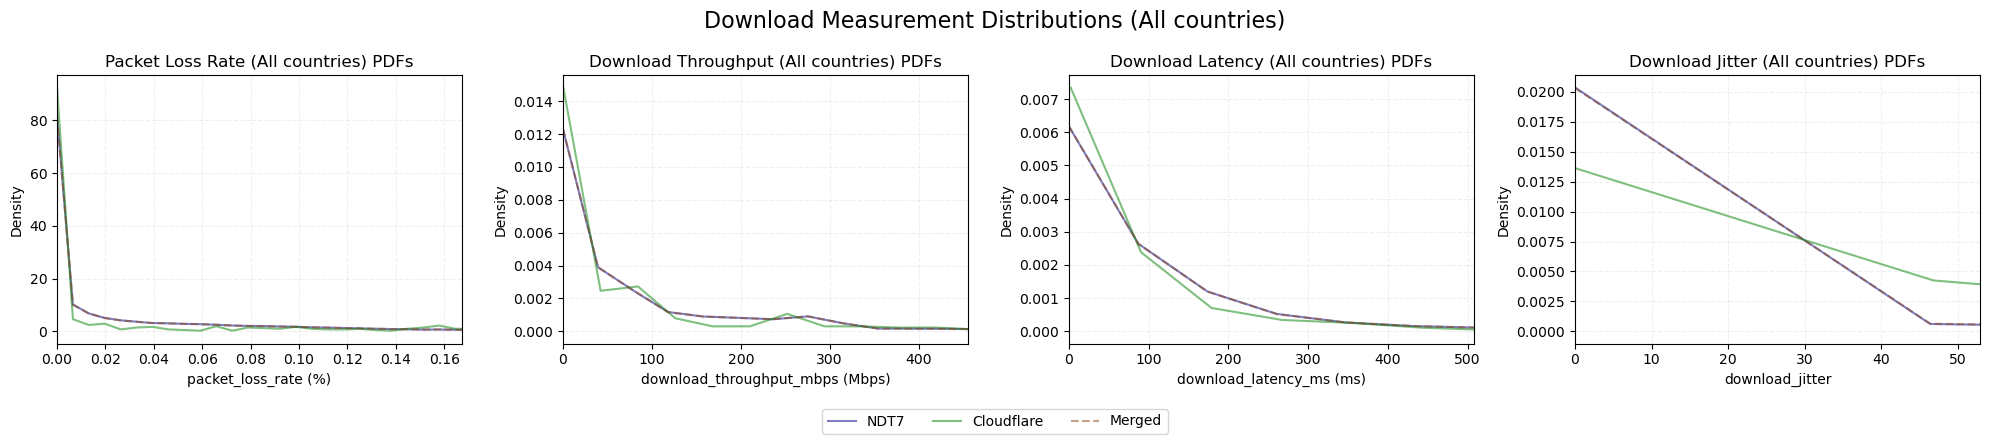

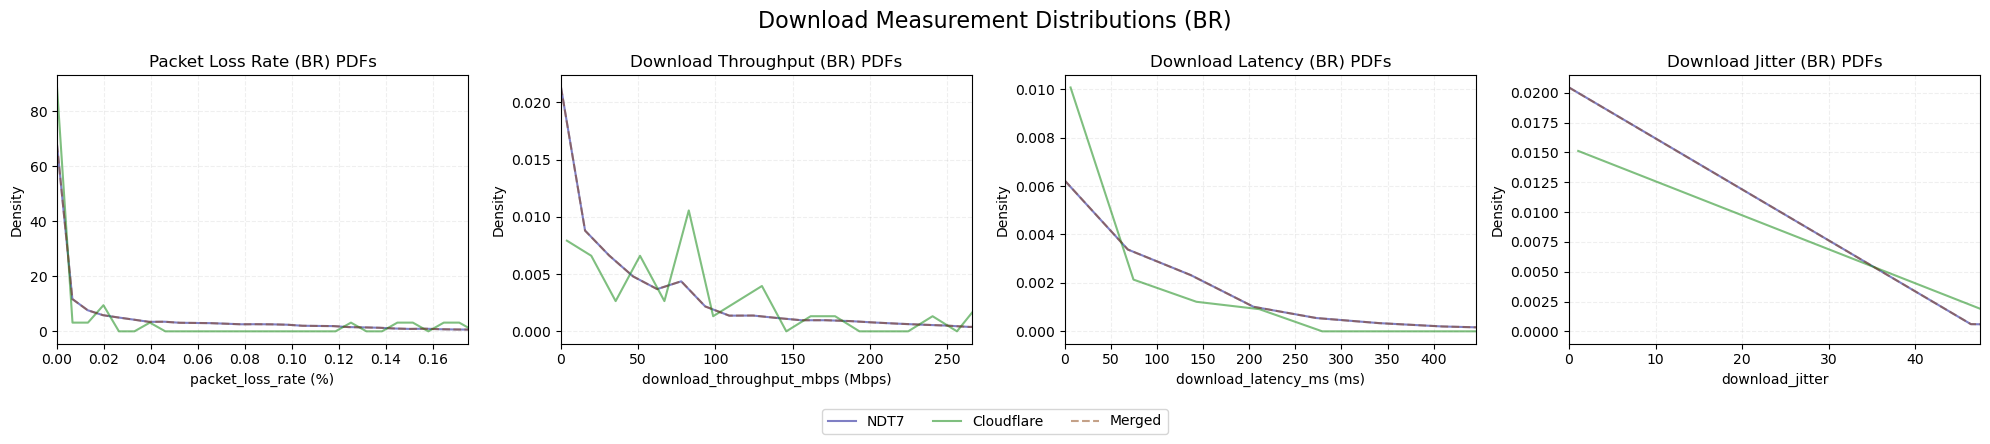

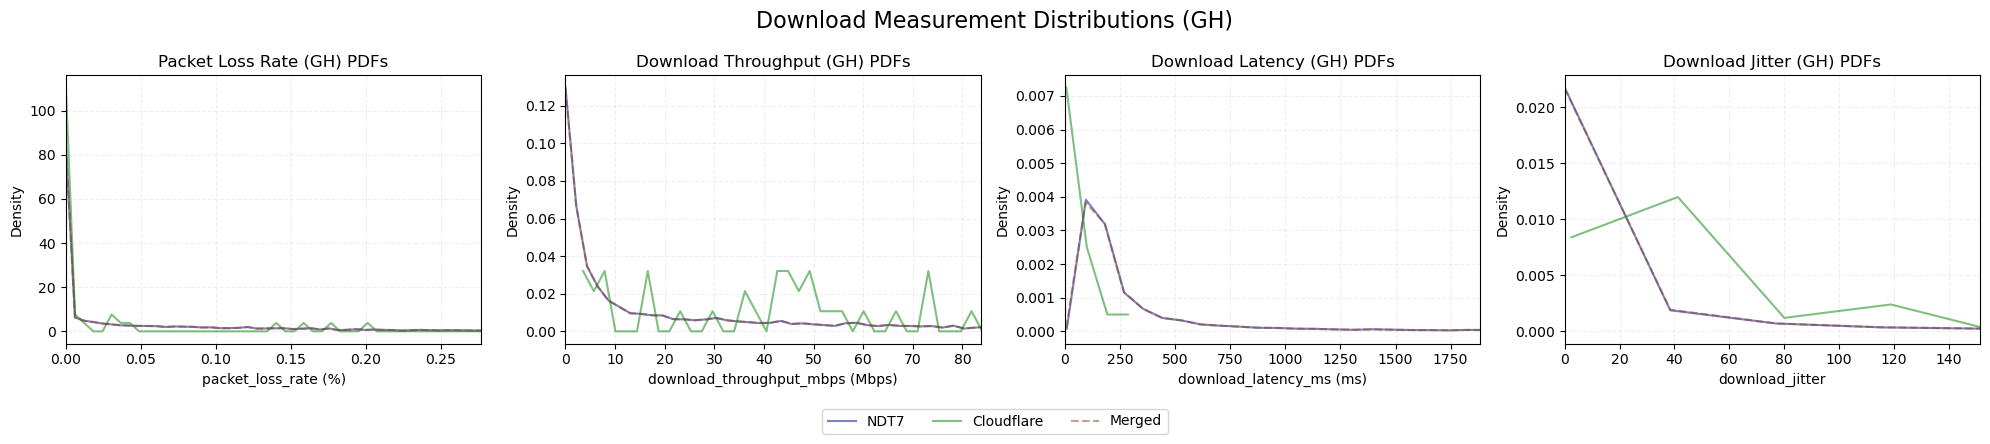

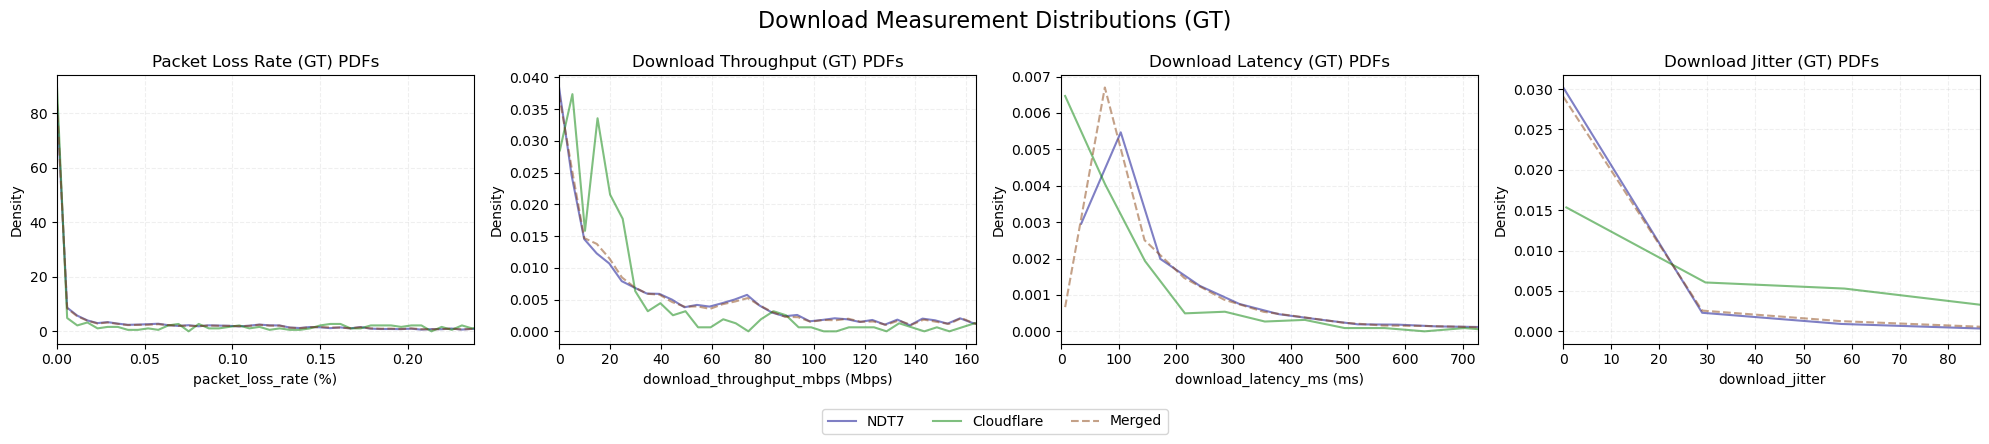

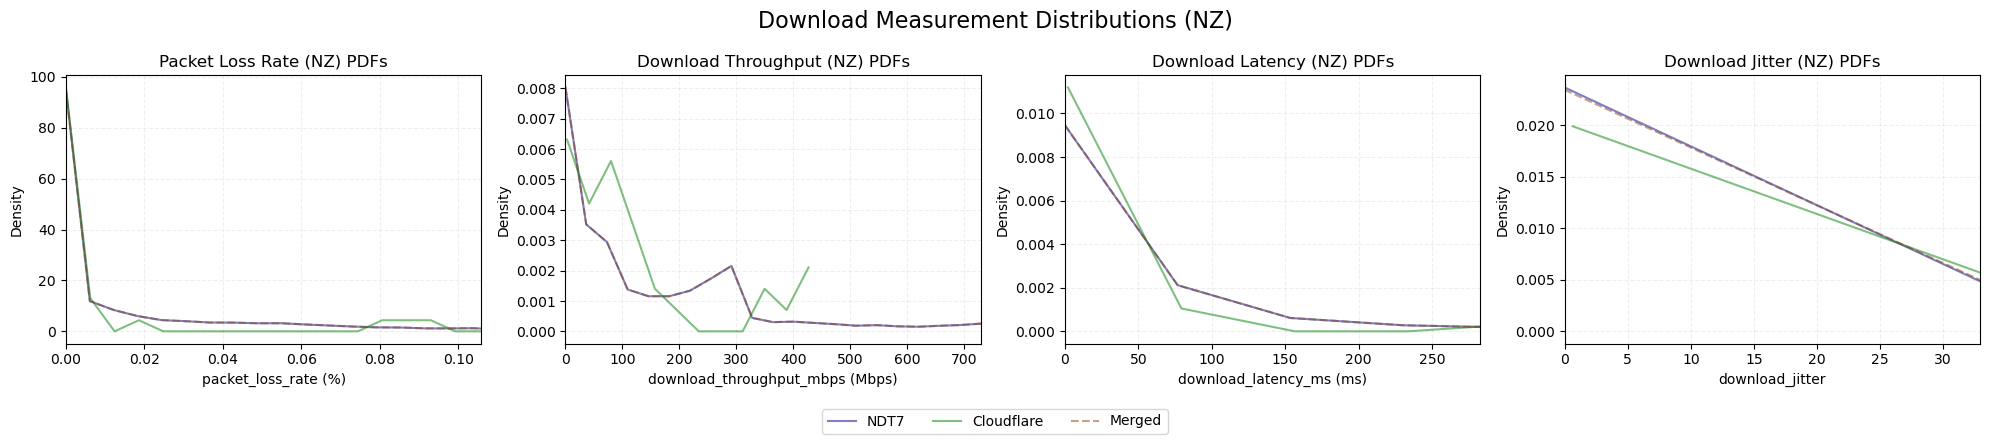

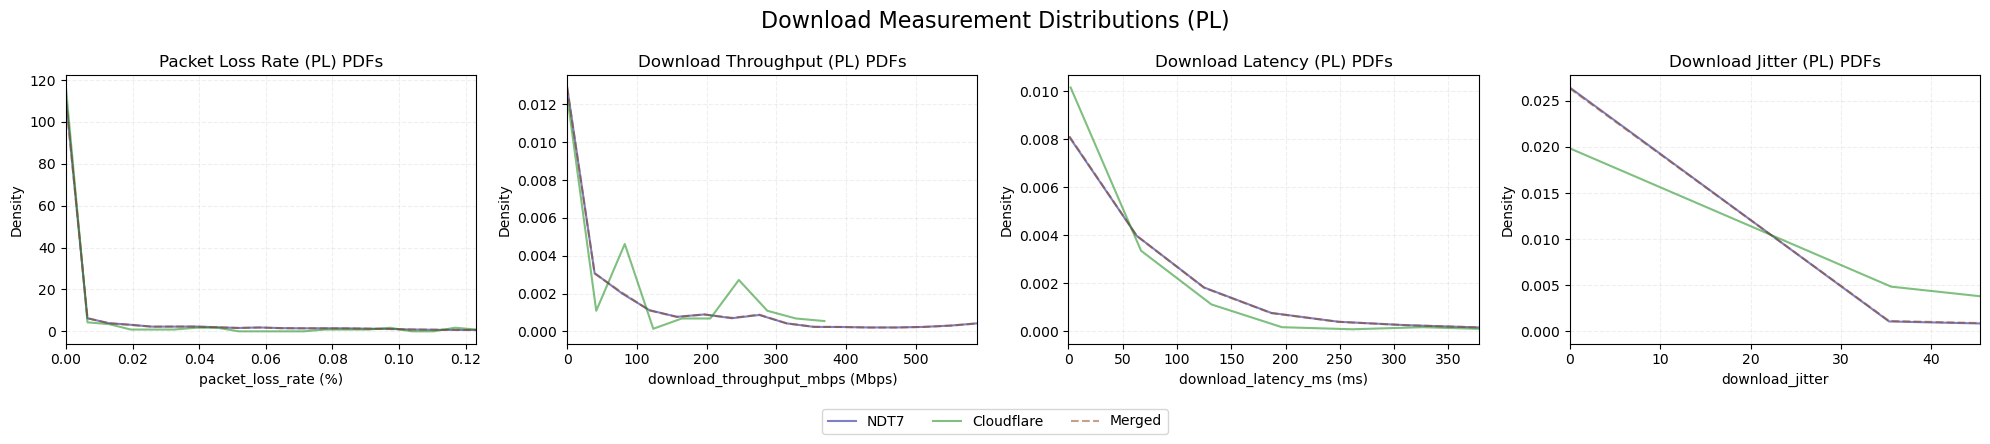




--------------------------------





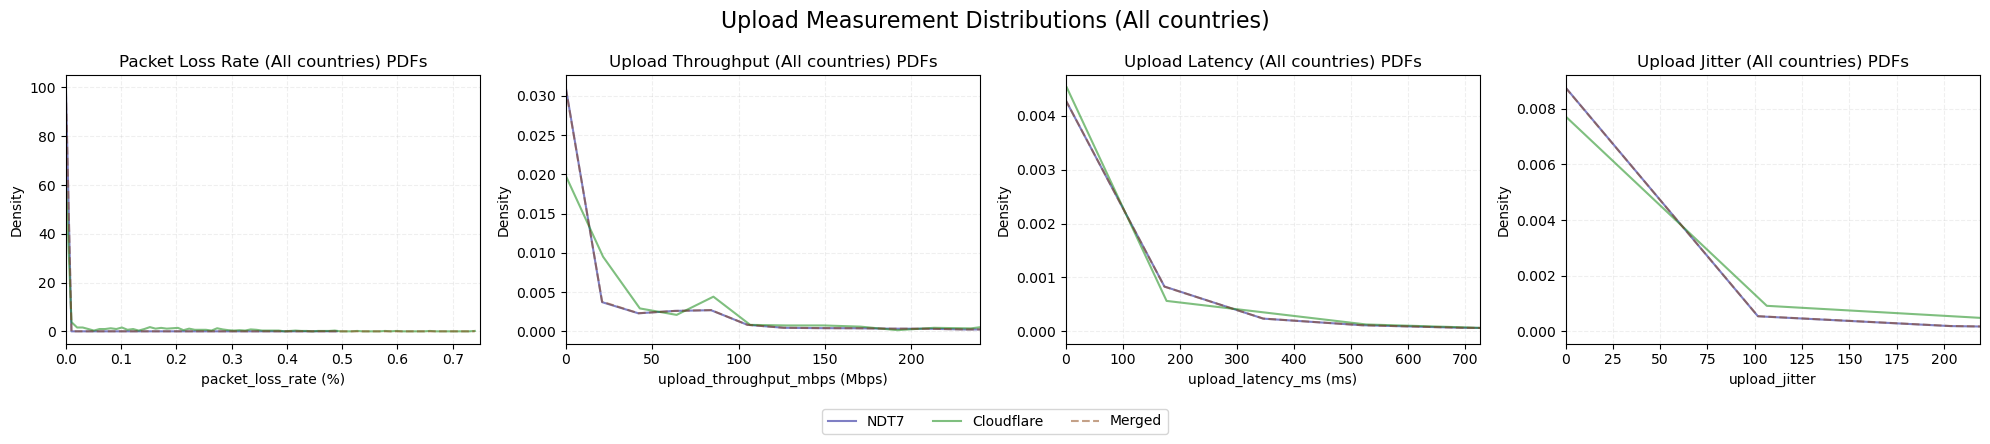

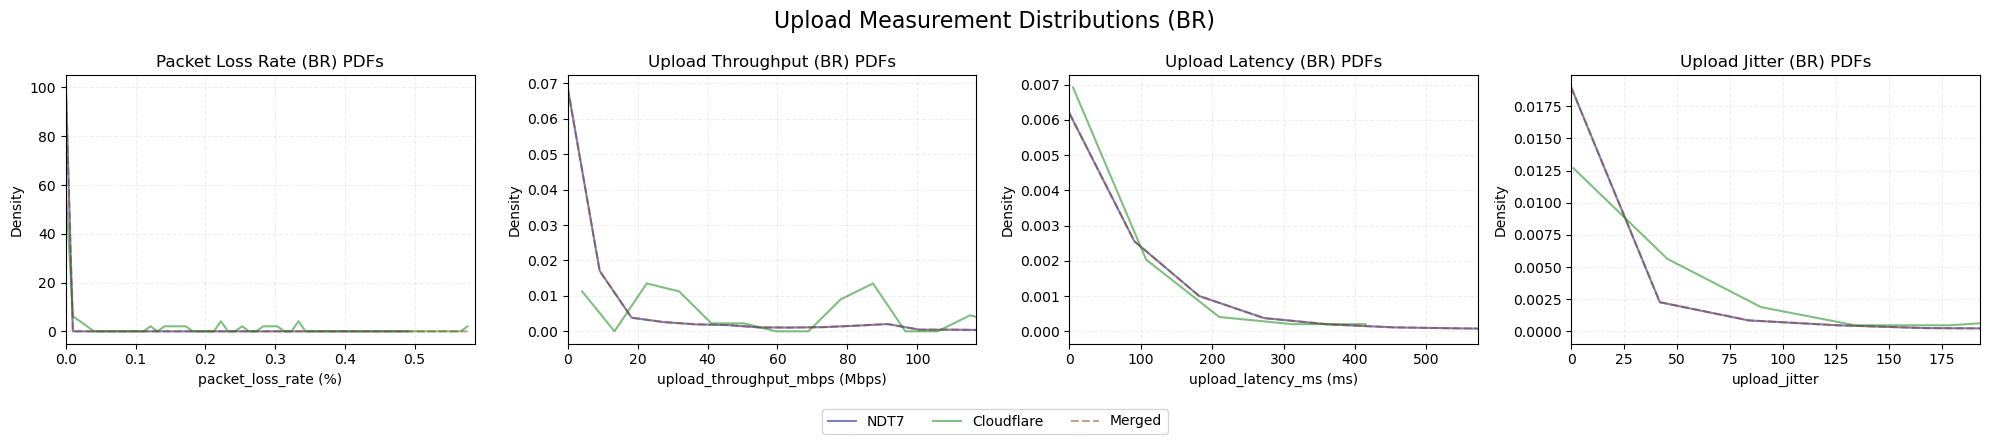

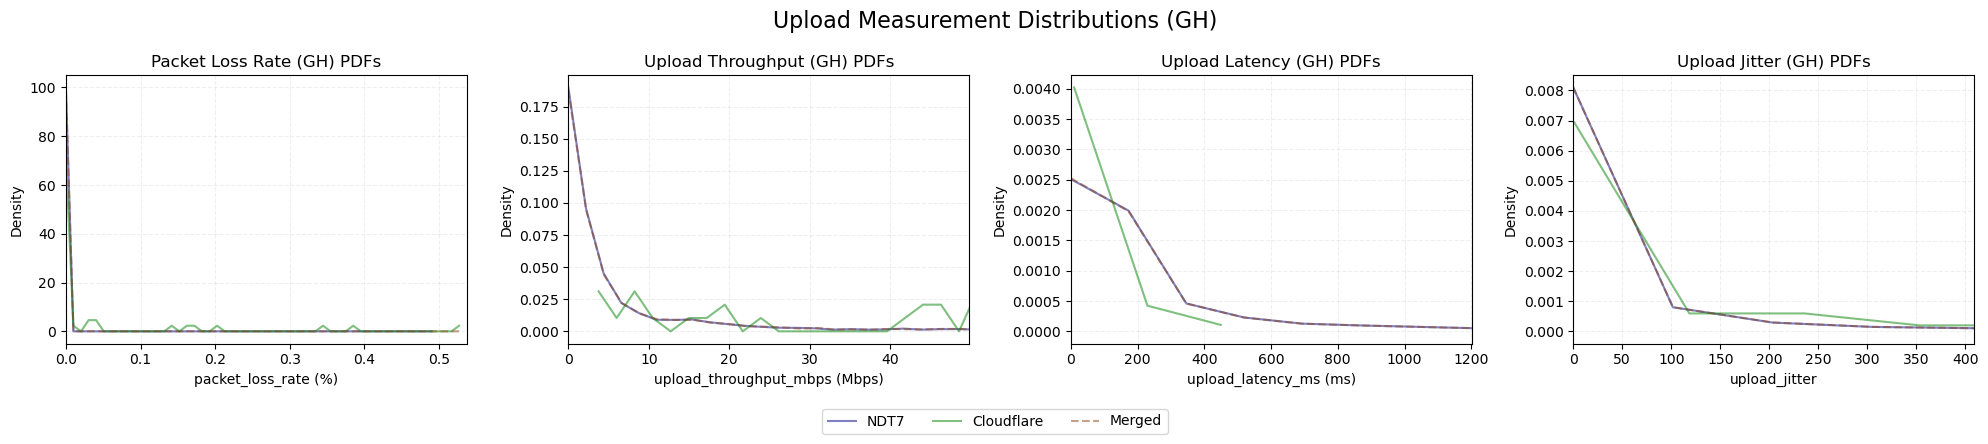

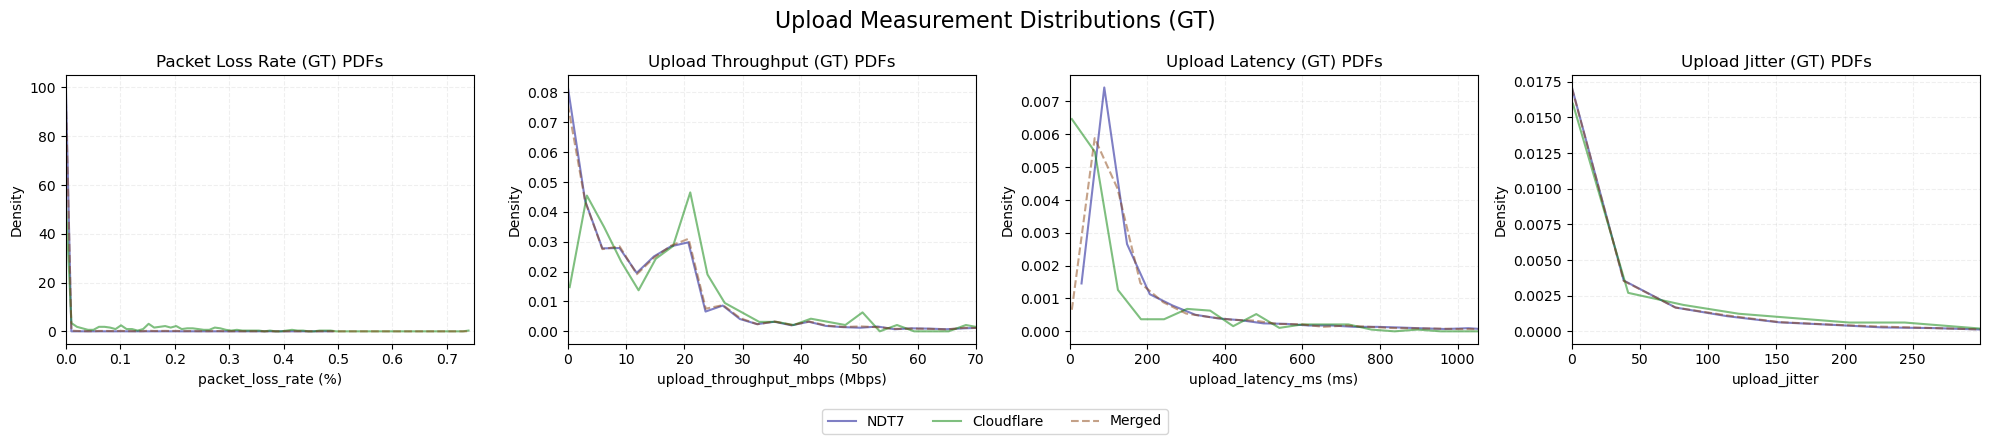

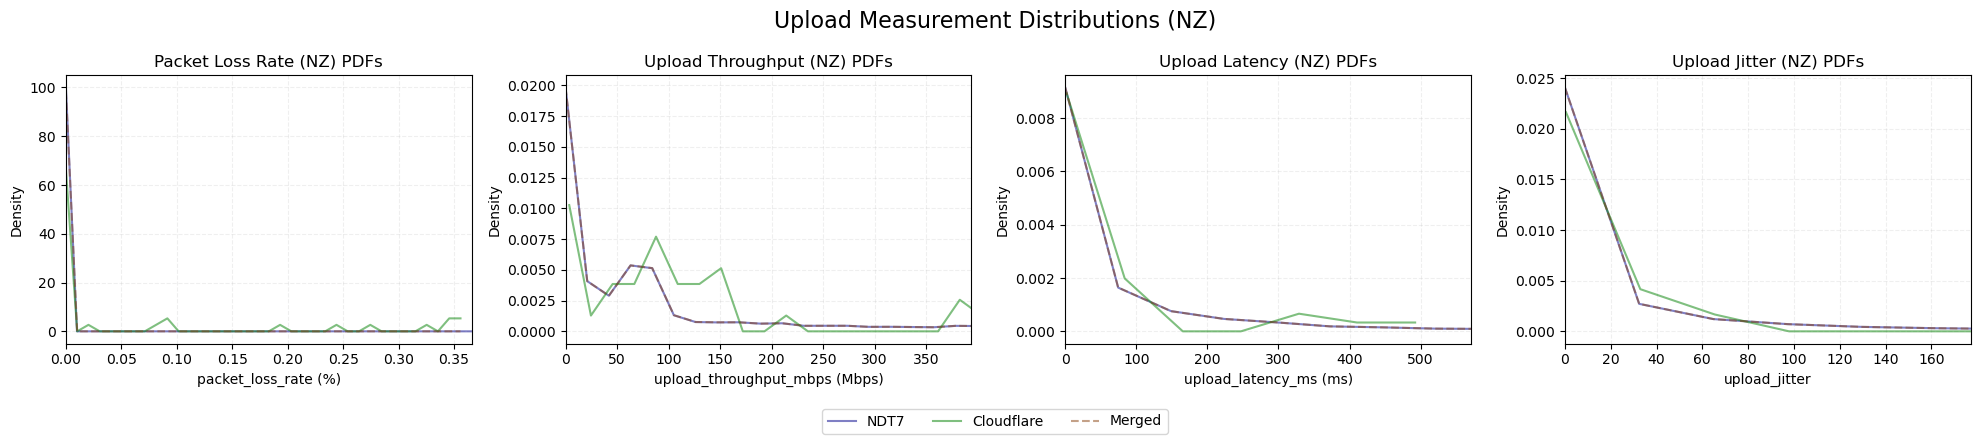

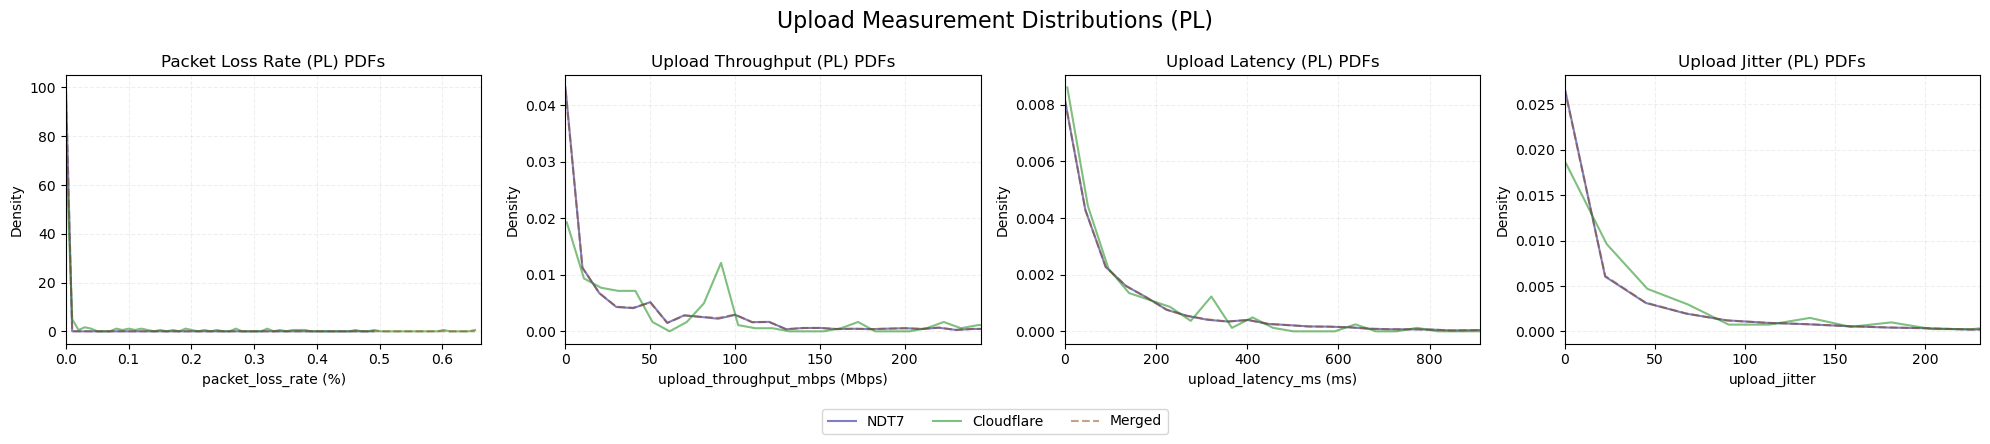

In [15]:
print('Mean-Generated Cloudflare')

plot_distribution_download(ndt7_download, cf_data_mean, 'All countries')
for country_iso in countries:
    plot_distribution_download(ndt7_download, cf_data_mean, country_iso)

print('\n\n\n--------------------------------\n\n\n')

plot_distribution_upload(ndt7_upload, cf_data_mean, 'All countries')
for country_iso in countries:
    plot_distribution_upload(ndt7_upload, cf_data_mean, country_iso)

Median-Generated Cloudflare


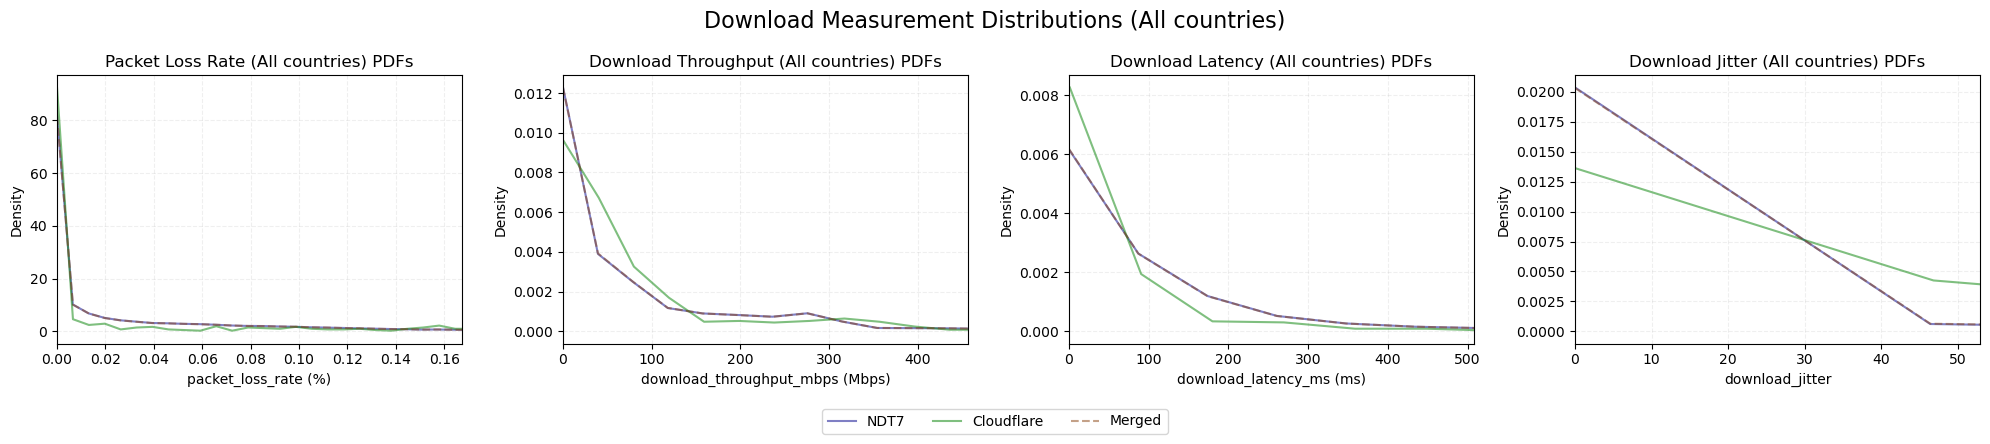

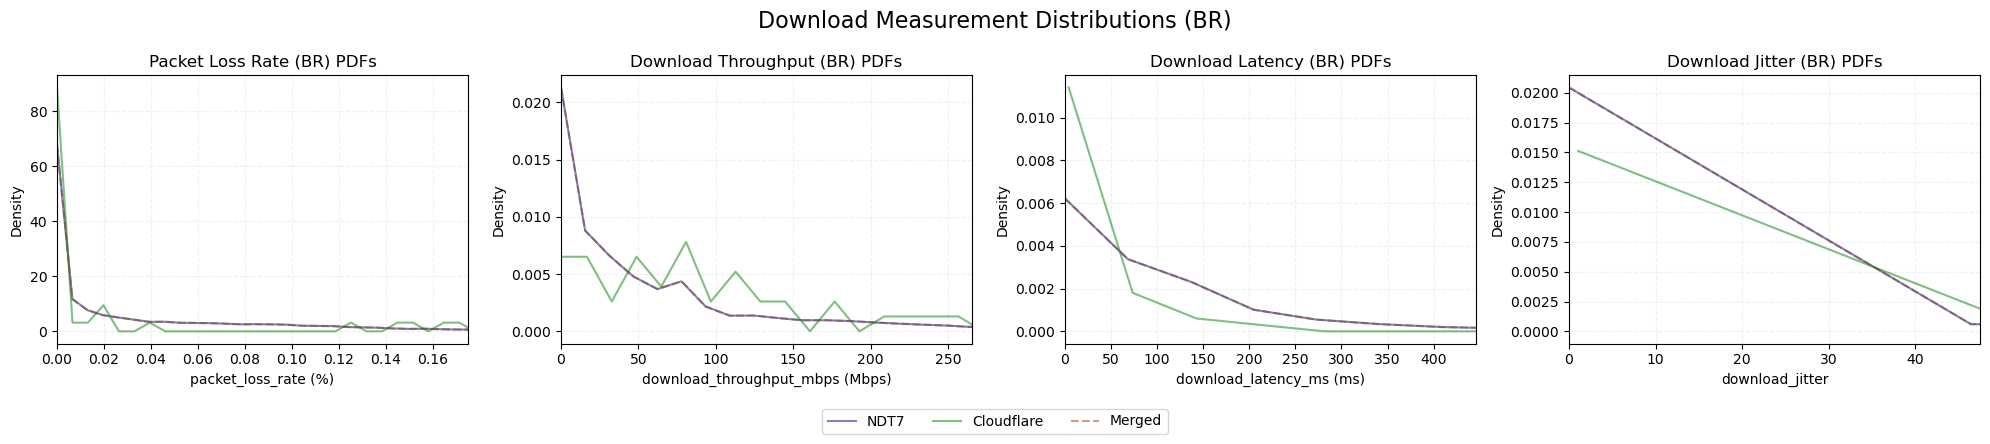

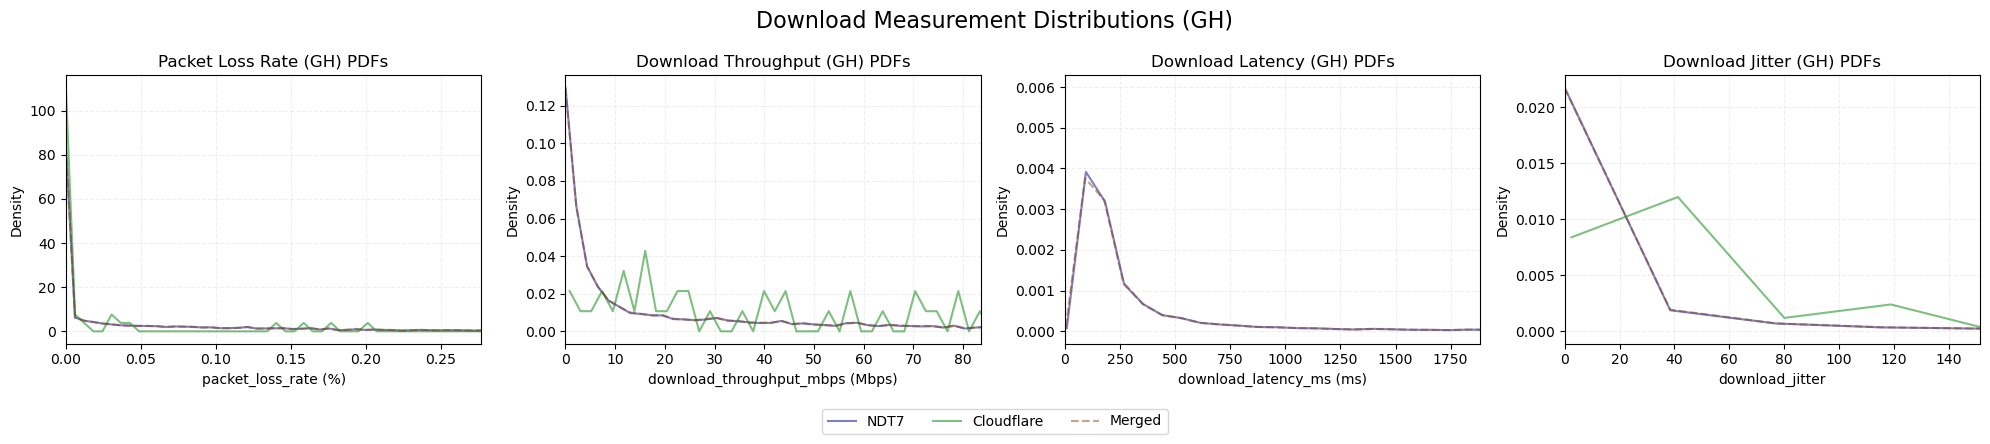

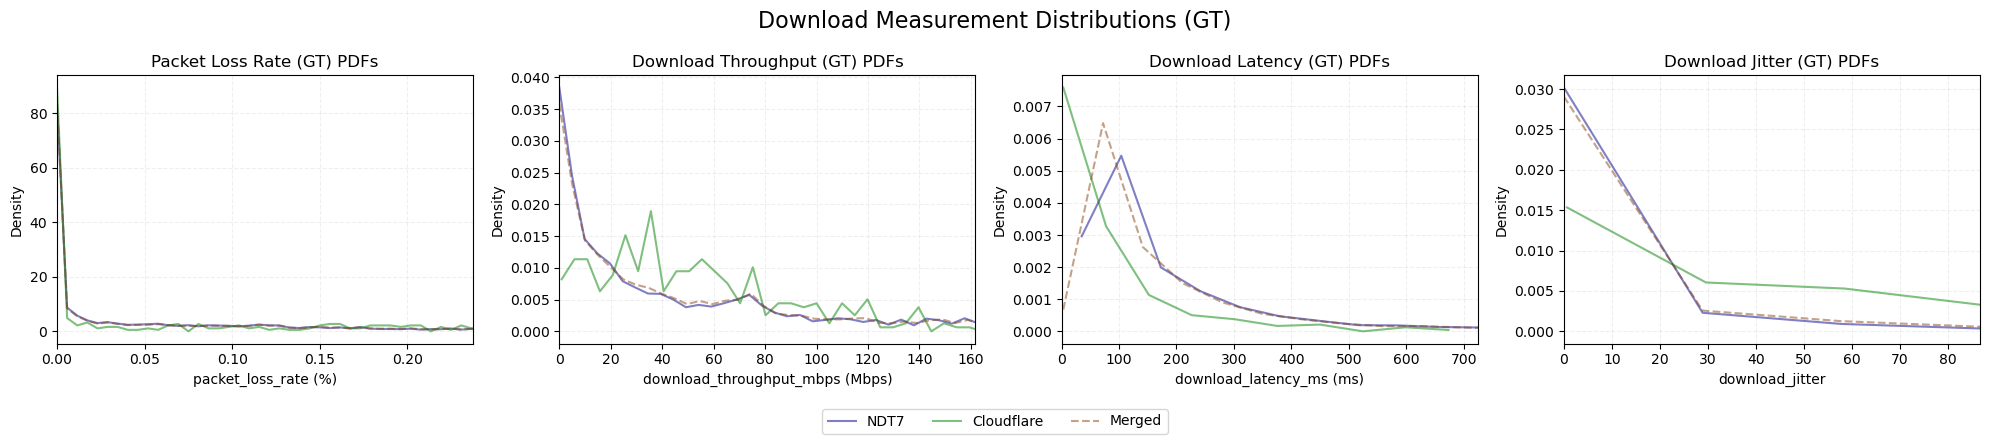

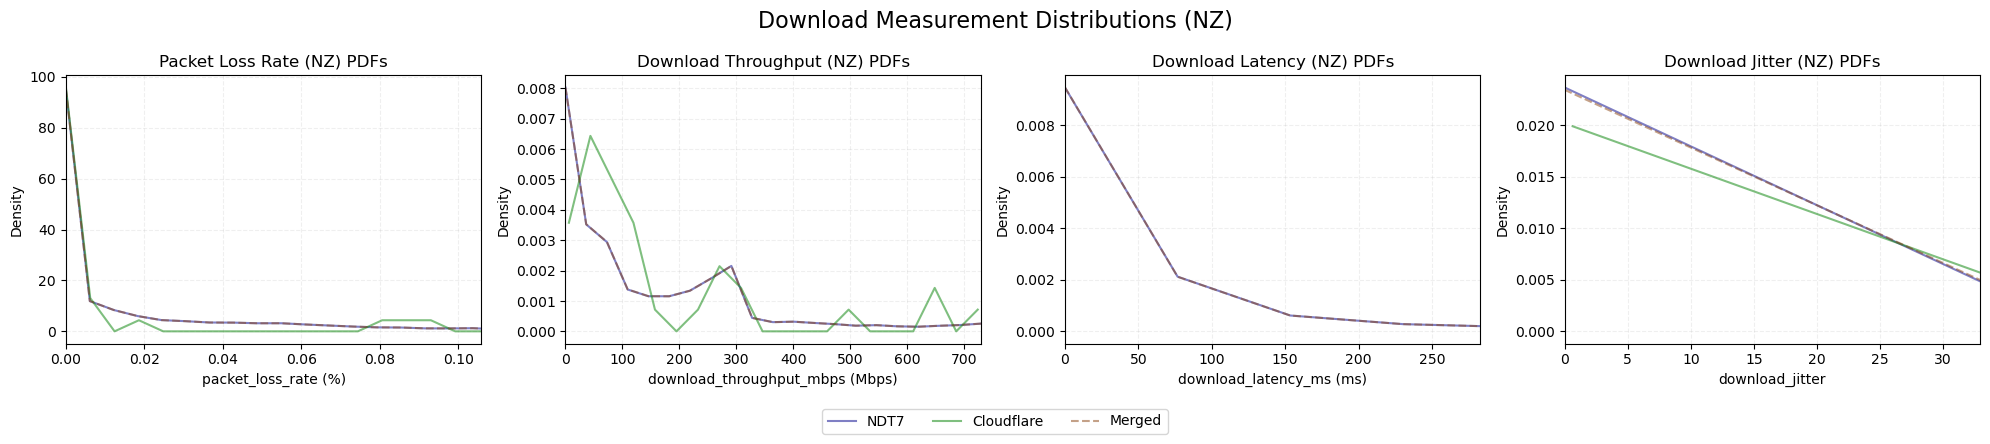

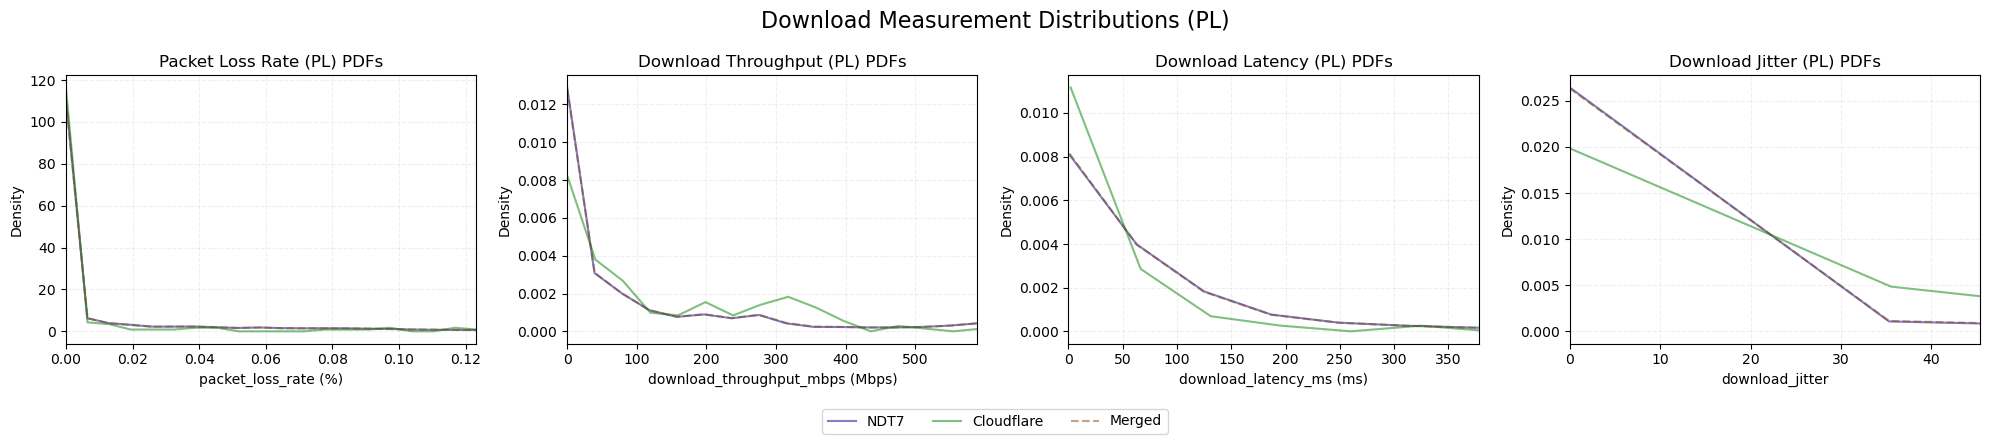




--------------------------------





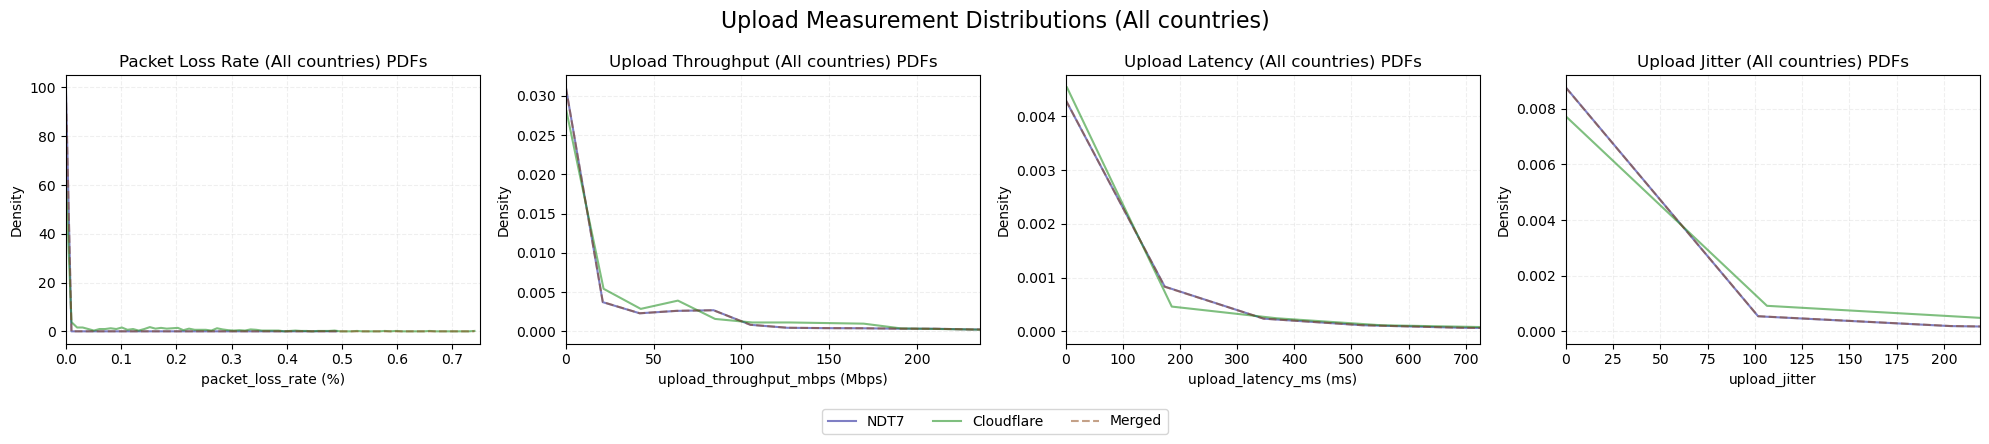

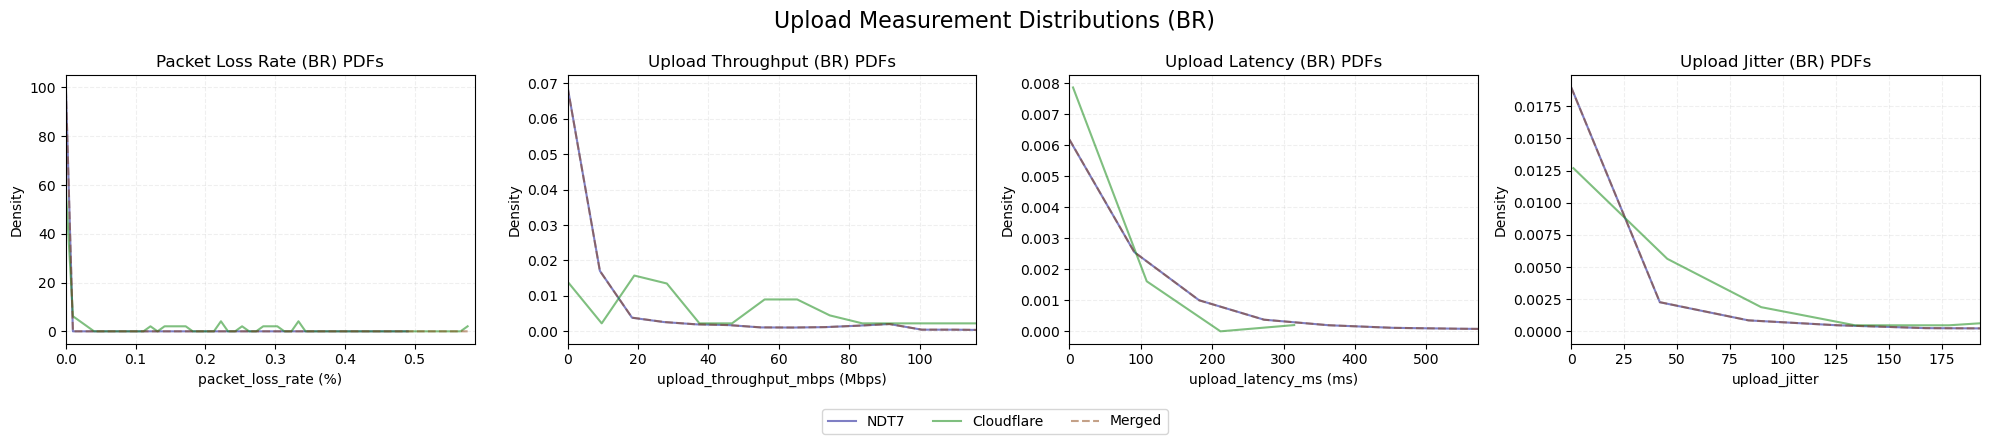

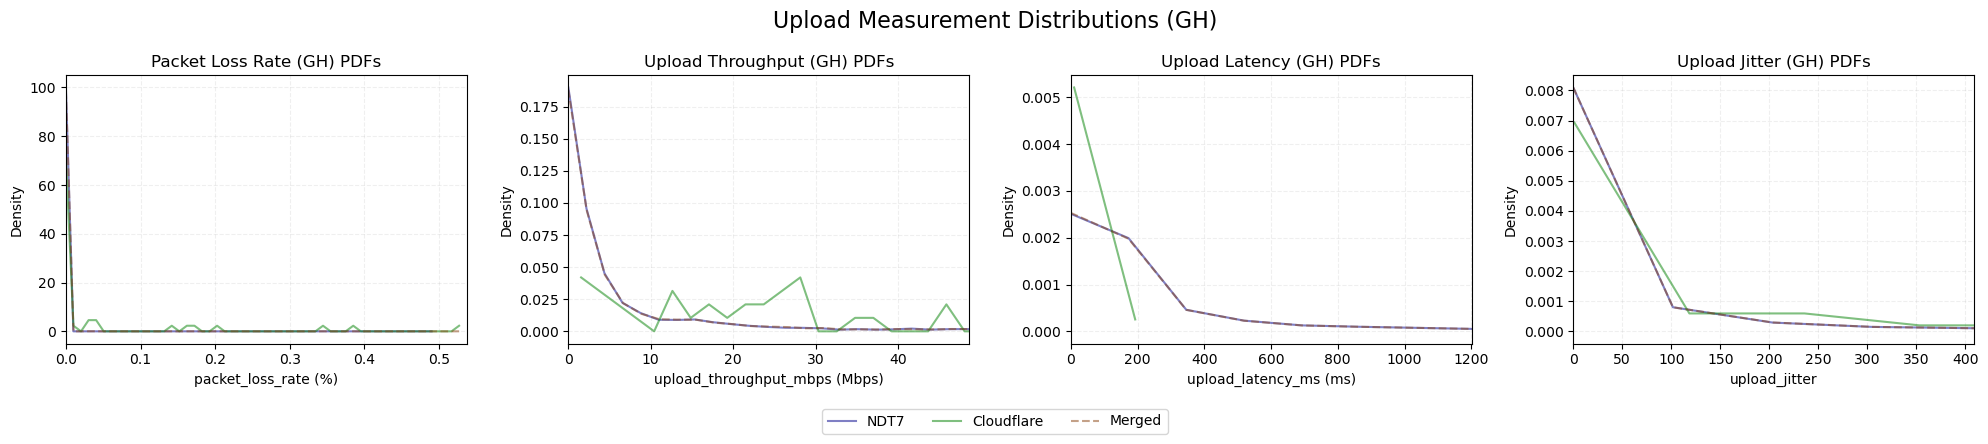

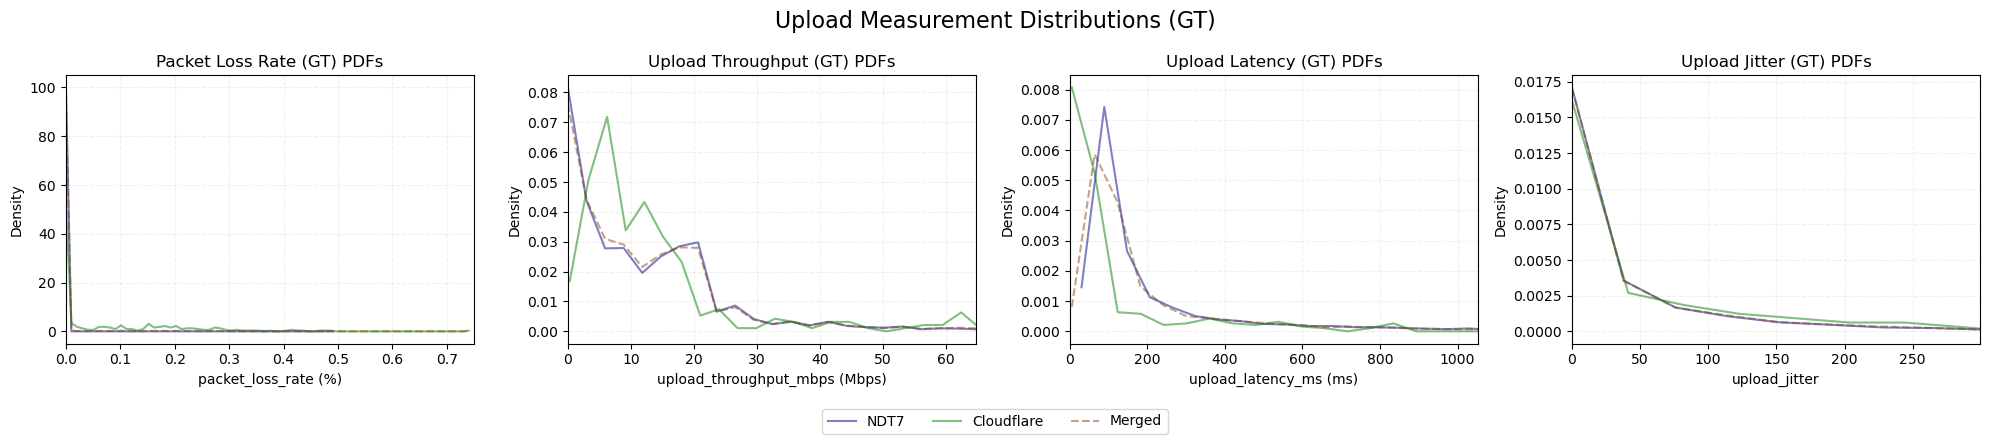

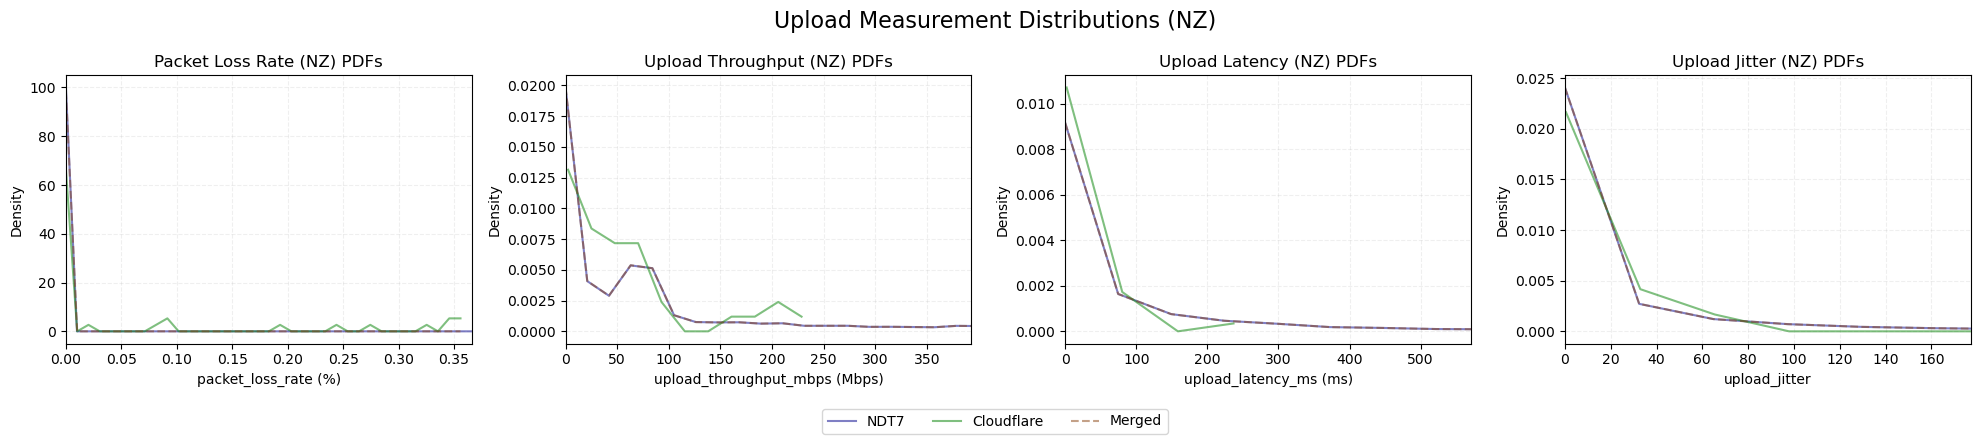

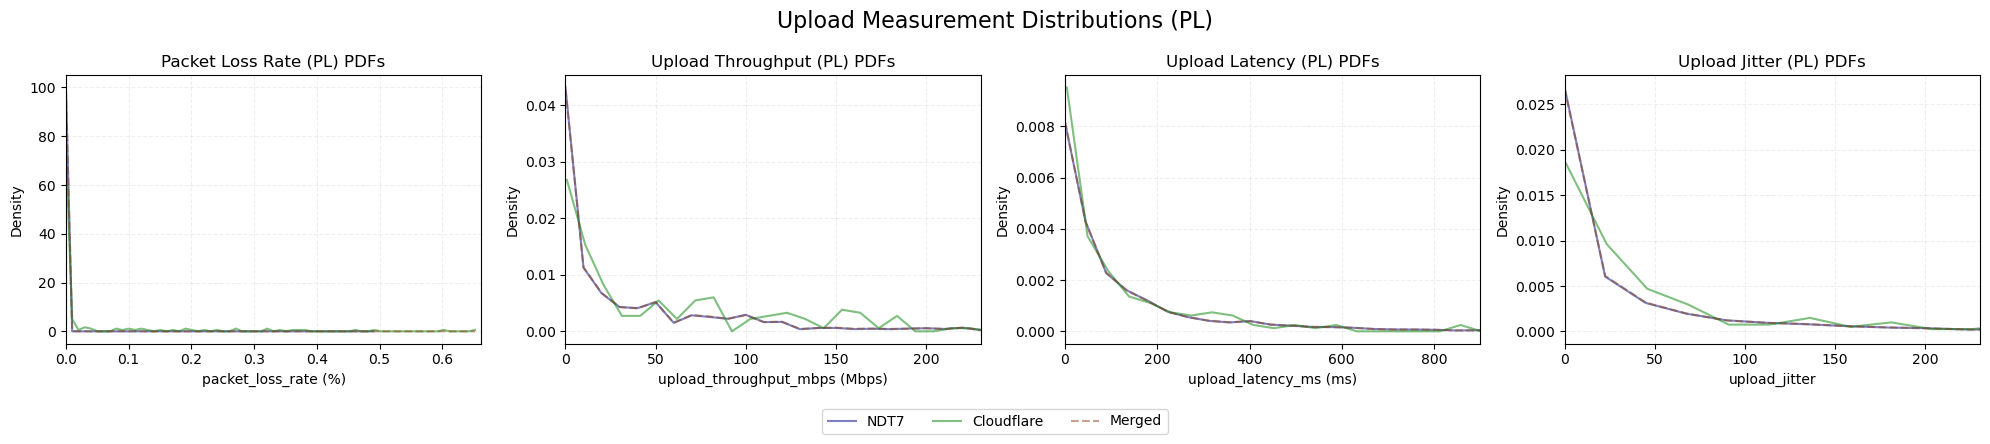

In [16]:
print('Median-Generated Cloudflare')

plot_distribution_download(ndt7_download, cf_data_median, 'All countries')
for country_iso in countries:
    plot_distribution_download(ndt7_download, cf_data_median, country_iso)

print('\n\n\n--------------------------------\n\n\n')

plot_distribution_upload(ndt7_upload, cf_data_median, 'All countries')
for country_iso in countries:
    plot_distribution_upload(ndt7_upload, cf_data_median, country_iso)

90th Percentile-Generated Cloudflare


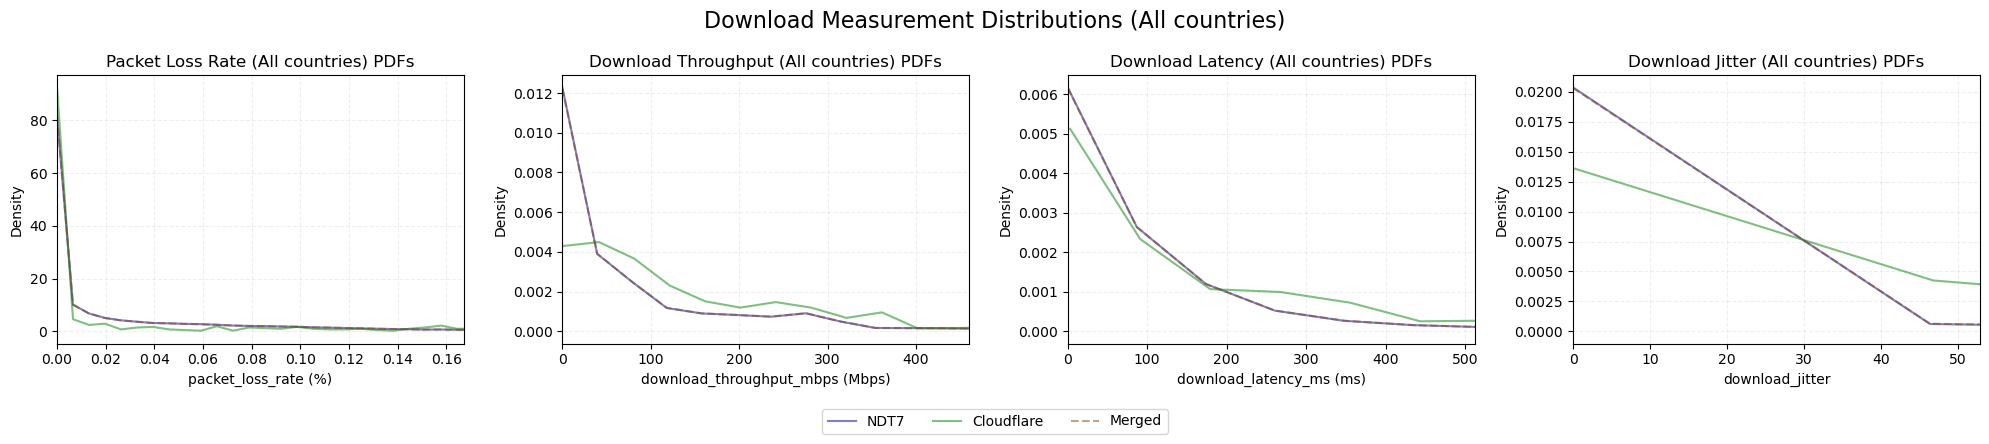

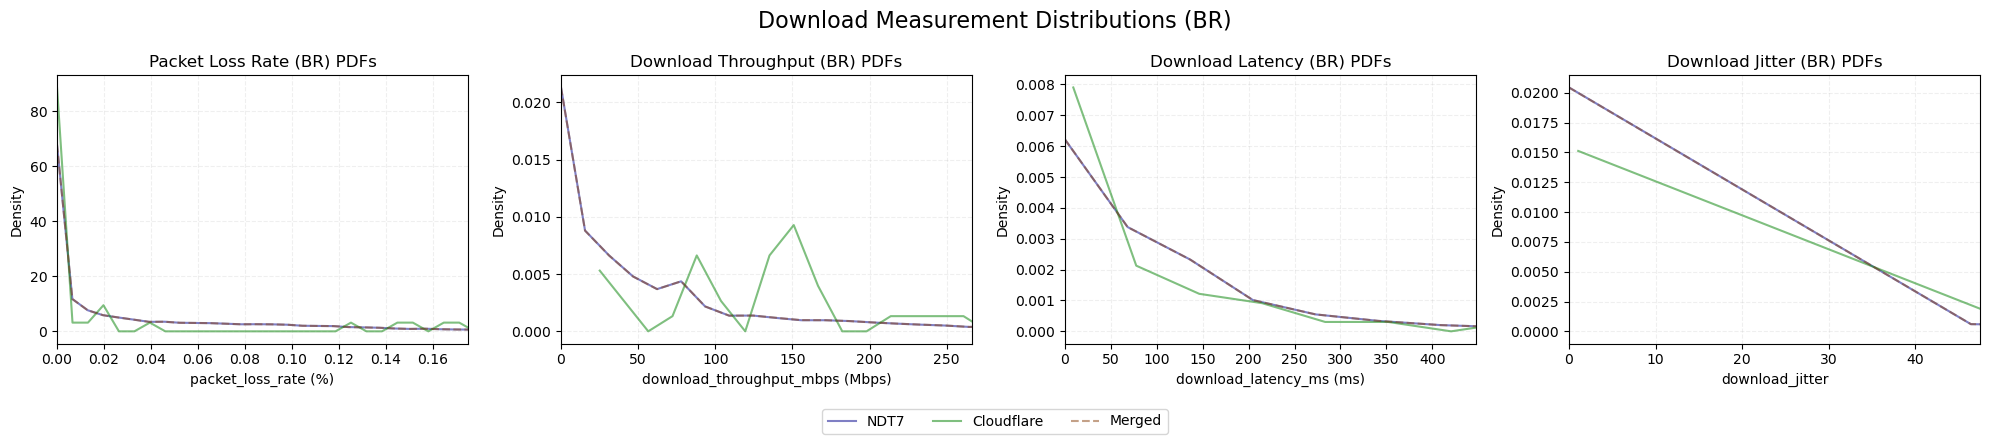

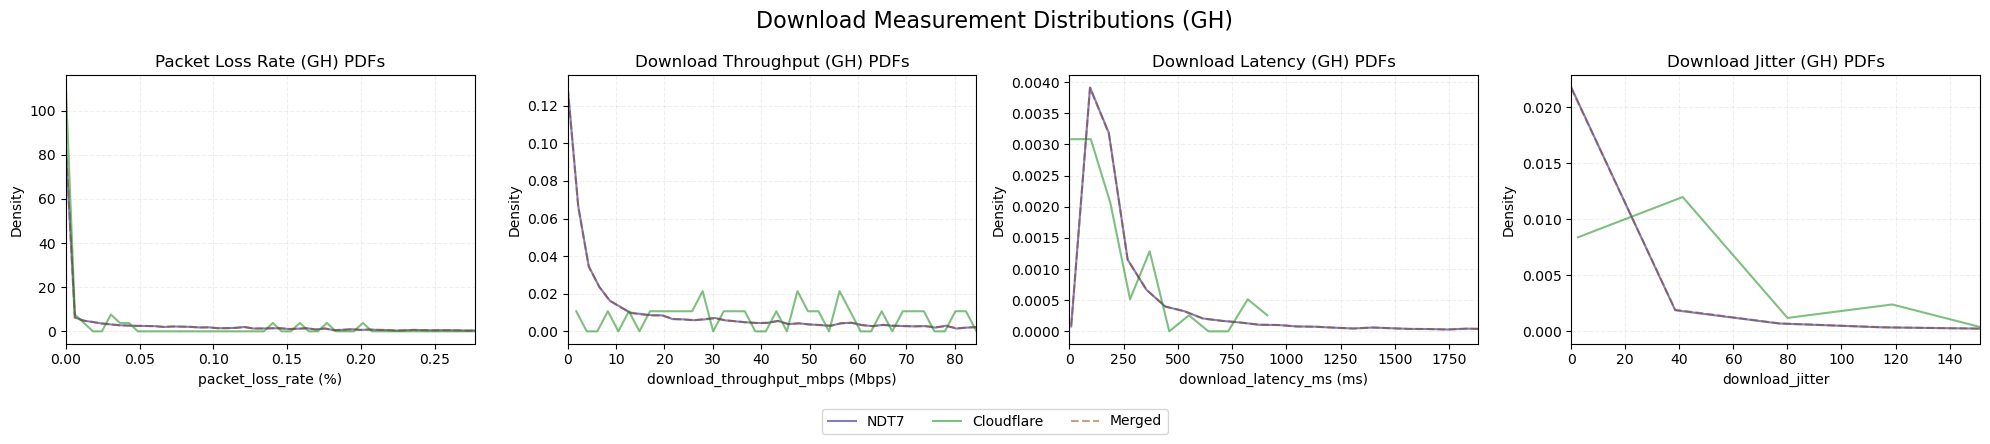

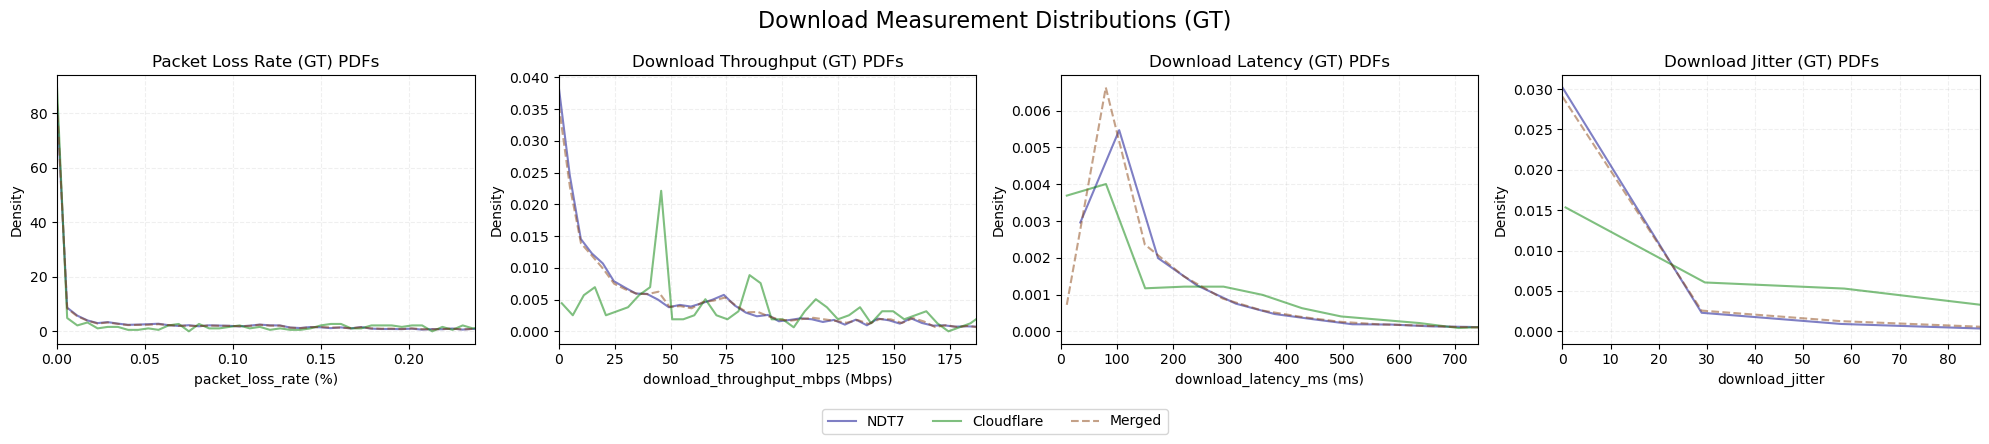

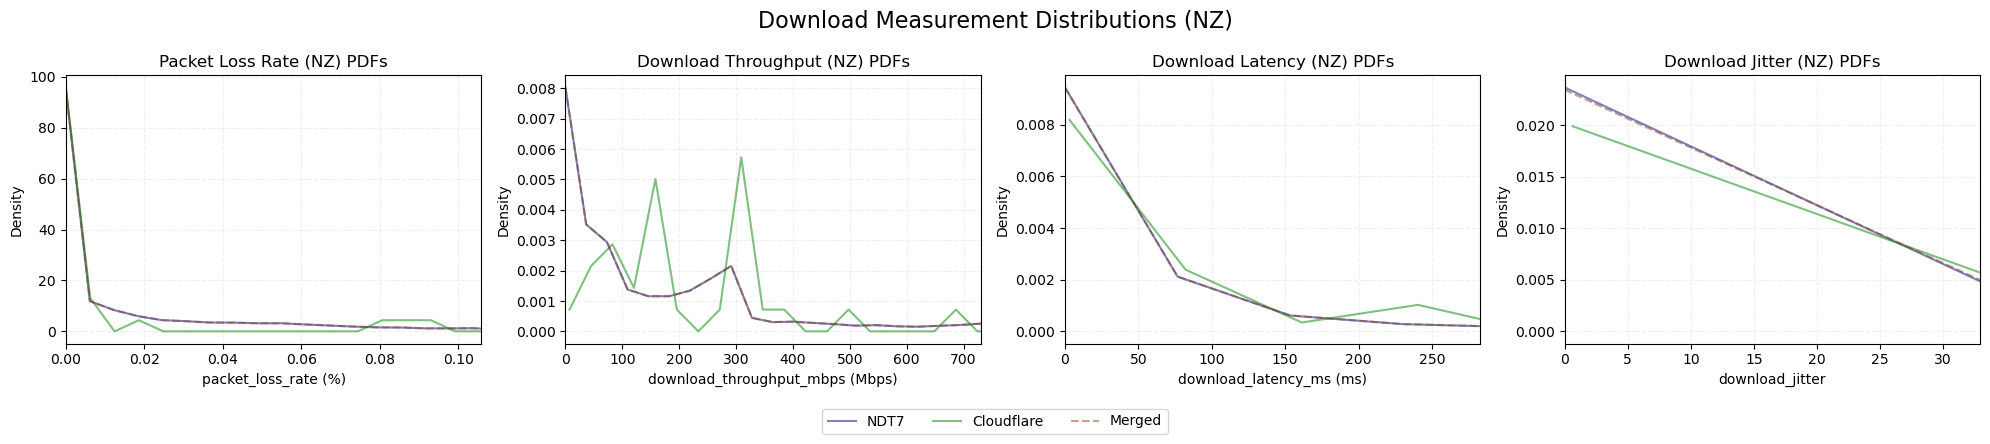

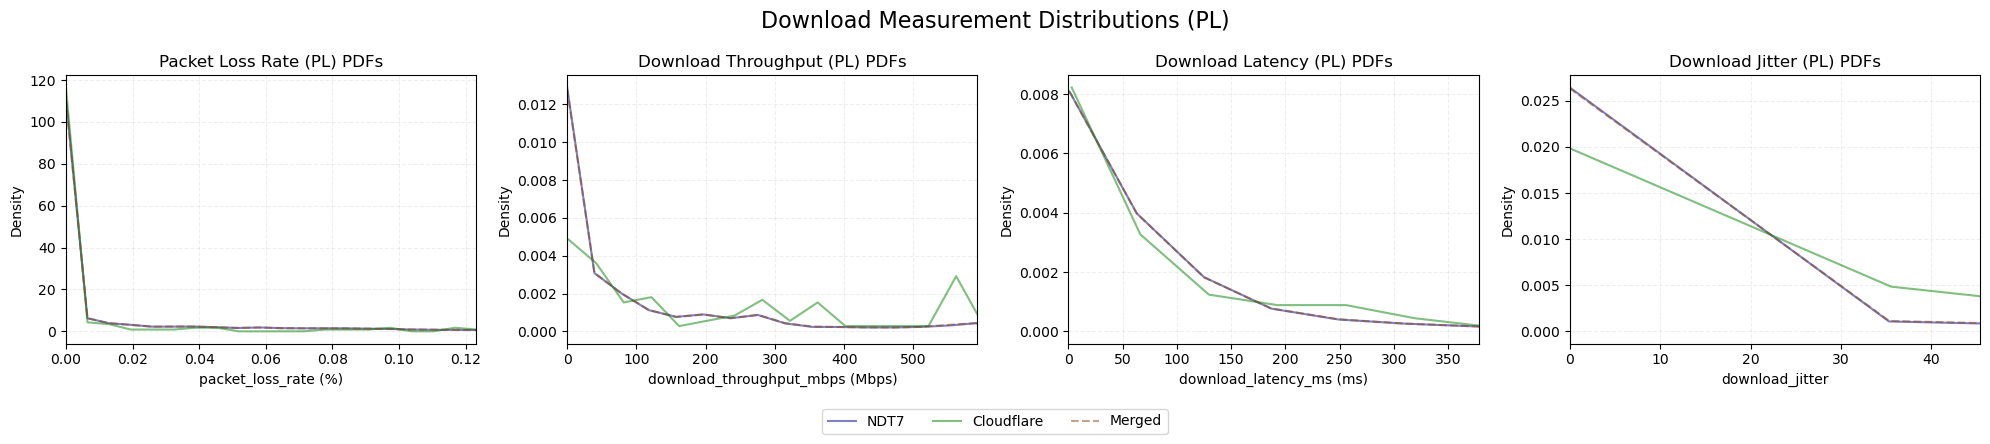




--------------------------------





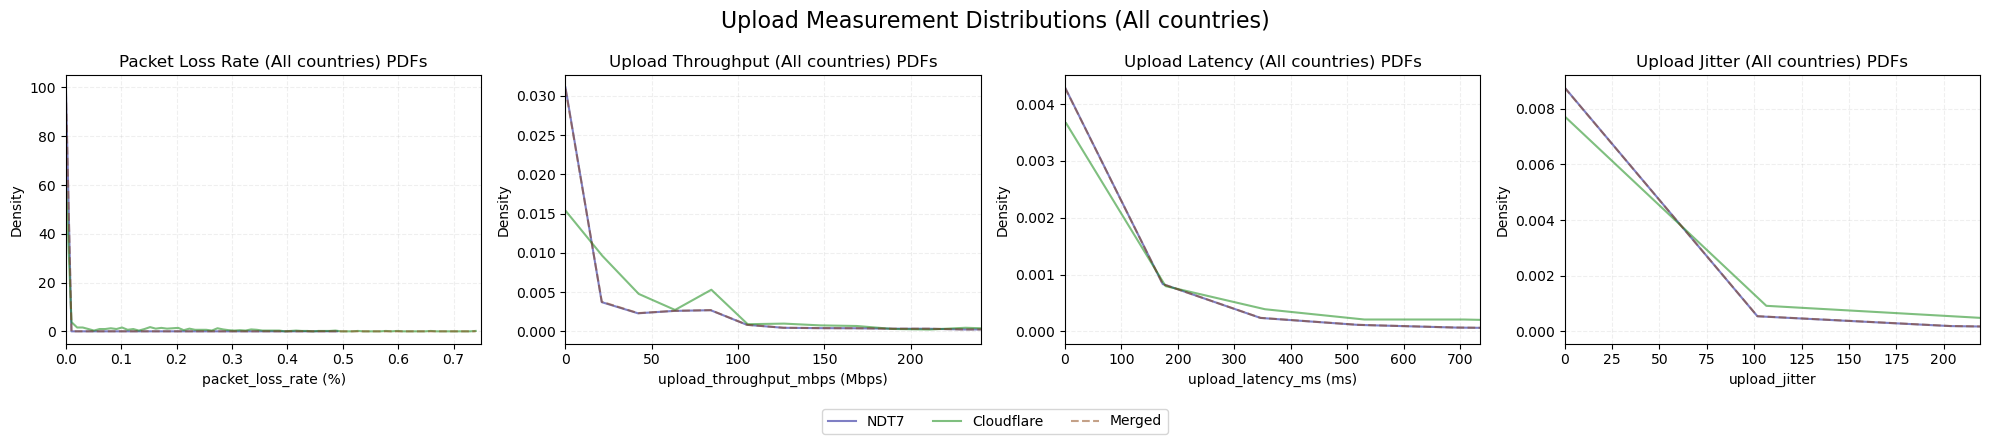

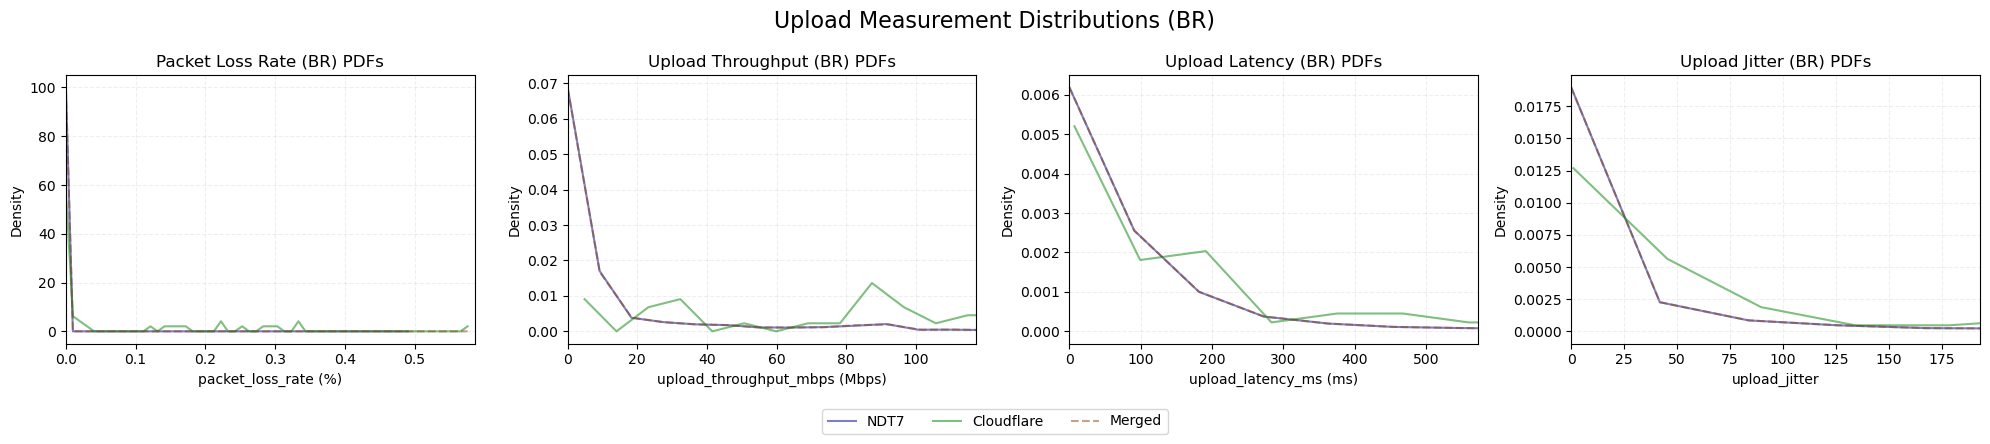

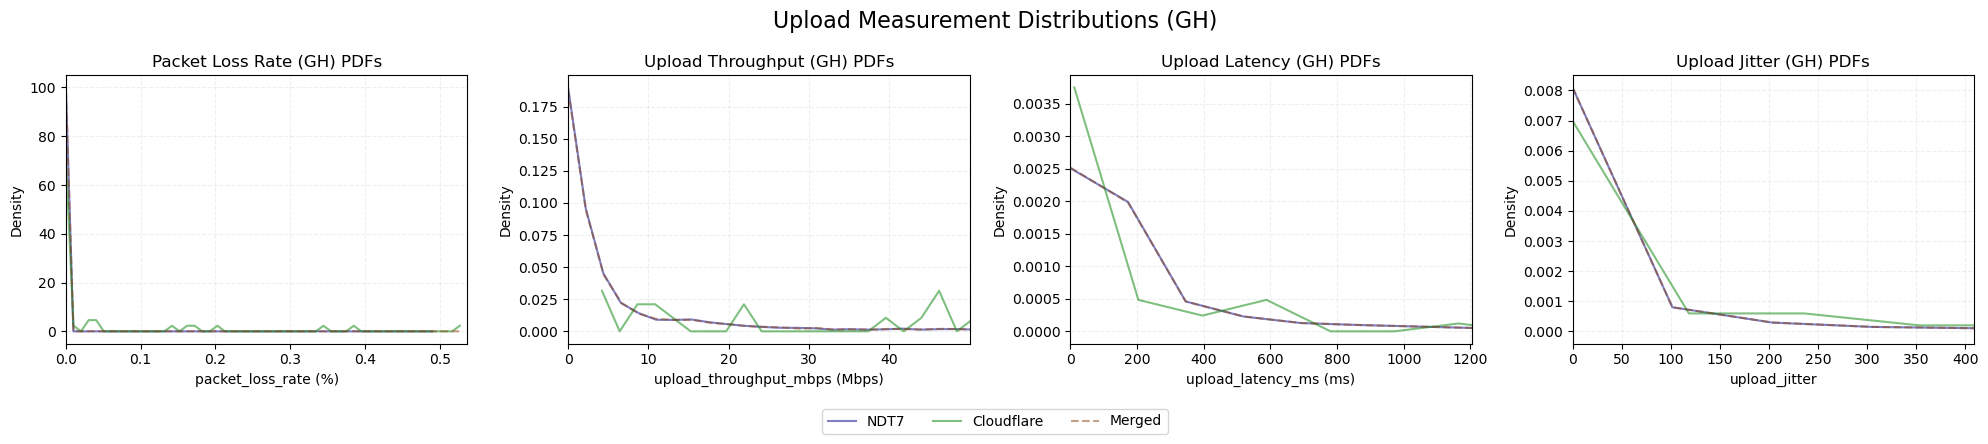

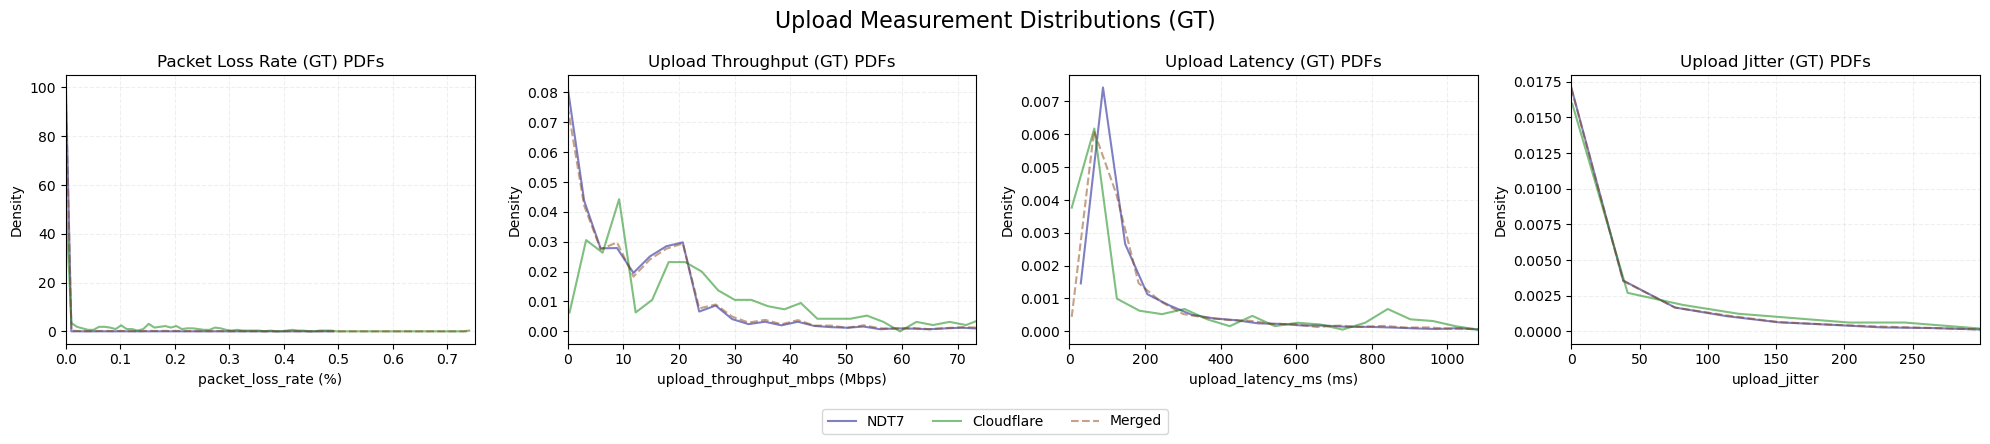

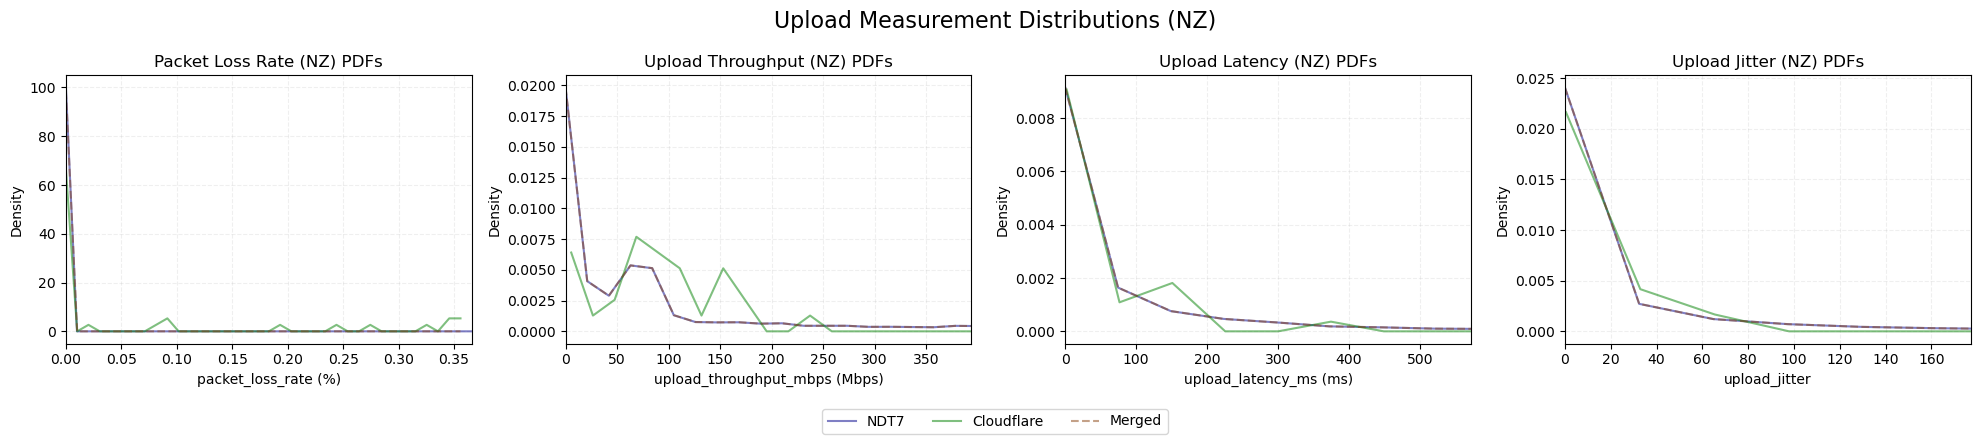

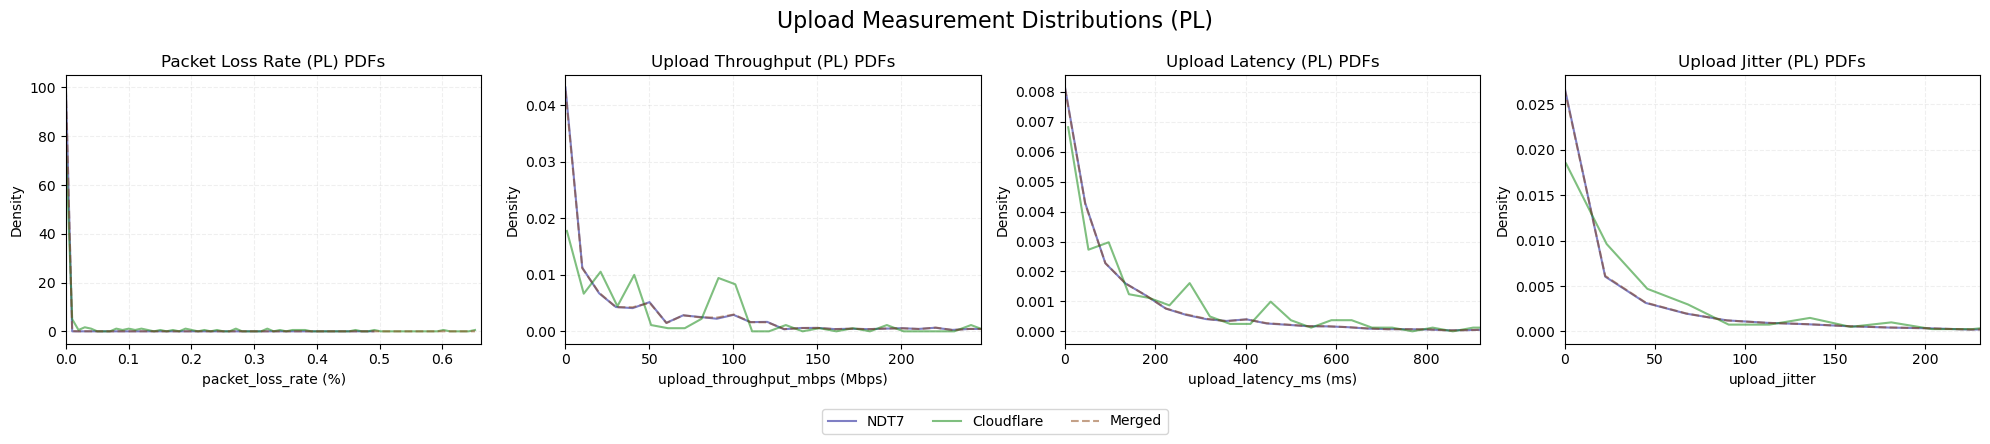

In [17]:
print('90th Percentile-Generated Cloudflare')

plot_distribution_download(ndt7_download, cf_data_90th_percentile, 'All countries')
for country_iso in countries:
    plot_distribution_download(ndt7_download, cf_data_90th_percentile, country_iso)

print('\n\n\n--------------------------------\n\n\n')

plot_distribution_upload(ndt7_upload, cf_data_90th_percentile, 'All countries')
for country_iso in countries:
    plot_distribution_upload(ndt7_upload, cf_data_90th_percentile, country_iso)

In [18]:
def get_histogram(data, bin_width=None):
    num_bins = 100
    if bin_width is not None:
        num_bins = int((np.max(data) - np.min(data)) / bin_width)
    return np.histogram(data,bins=num_bins, density=True)

def plot_throughputs_upload():
    legend_added = False
    fig, axes = plt.subplots(5, 3, figsize=(21, 20))
    for i, country_iso in enumerate(countries):

        ndt7_upload_measurement = ndt7_upload[ndt7_upload['country_iso'] == country_iso][['upload_throughput_mbps']].copy().dropna()
        cf_upload_mean = cf_data_mean[cf_data_mean['country_iso'] == country_iso][['upload_throughput_mbps']].copy().dropna()
        cf_upload_median = cf_data_median[cf_data_median['country_iso'] == country_iso][['upload_throughput_mbps']].copy().dropna()
        cf_upload_90th = cf_data_90th_percentile[cf_data_90th_percentile['country_iso'] == country_iso][['upload_throughput_mbps']].copy().dropna()


        counts_ndt7_up, bin_edges_ndt7_up = get_histogram(ndt7_upload_measurement['upload_throughput_mbps'])
        ndt_up_bin_width = bin_edges_ndt7_up[1] - bin_edges_ndt7_up[0]

        counts_cf_mean_up, bin_edges_cf_mean_up = get_histogram(cf_upload_mean['upload_throughput_mbps'], ndt_up_bin_width)
        counts_cf_median_up, bin_edges_cf_median_up = get_histogram(cf_upload_median['upload_throughput_mbps'], ndt_up_bin_width)
        counts_cf_90_up, bin_edges_cf_90_up = get_histogram(cf_upload_90th['upload_throughput_mbps'], ndt_up_bin_width)

        lower_limit_up = 0
        upper_limit_up = max(1,
            np.max(cf_upload_mean['upload_throughput_mbps']),
            np.max(cf_upload_median['upload_throughput_mbps']),
            np.max(cf_upload_90th['upload_throughput_mbps'])
        )
        upper_limit_up = min(
            upper_limit_up,
            np.max(ndt7_upload_measurement['upload_throughput_mbps'])
        )

        ax_mean = axes[i,0]
        ax_median = axes[i,1]
        ax_90 = axes[i,2]
        if not legend_added:
            ax_mean.plot(bin_edges_ndt7_up[:-1], counts_ndt7_up, label='NDT7', alpha=0.5, color='blue')
            ax_mean.plot(bin_edges_cf_mean_up[:-1], counts_cf_mean_up, label='Cloudflare Mean', alpha=0.5, color='green')
            ax_median.plot(bin_edges_cf_median_up[:-1], counts_cf_median_up, label='Cloudflare Median', alpha=0.5, color='purple')
            ax_90.plot(bin_edges_cf_90_up[:-1], counts_cf_90_up, label='Cloudflare 90th Percentile', alpha=0.5, color='orange')
            legend_added = True
        else:
            ax_mean.plot(bin_edges_ndt7_up[:-1], counts_ndt7_up, alpha=0.5, color='blue')
            ax_mean.plot(bin_edges_cf_mean_up[:-1], counts_cf_mean_up, alpha=0.5, color='green')
            ax_median.plot(bin_edges_cf_median_up[:-1], counts_cf_median_up, alpha=0.5, color='purple')
            ax_90.plot(bin_edges_cf_90_up[:-1], counts_cf_90_up, alpha=0.5, color='orange')
        ax_median.plot(bin_edges_ndt7_up[:-1], counts_ndt7_up, alpha=0.5, color='blue')
        ax_90.plot(bin_edges_ndt7_up[:-1], counts_ndt7_up, alpha=0.5, color='blue')
        for j in range(3):
            ax = axes[i,j]
            if j == 0:
                ax.set_title(f'{country_iso} Mean')
            elif j == 1:
                ax.set_title(f'{country_iso} Median')
            else: ax.set_title(f'{country_iso} 90th Percentile')
            ax.set_xlabel('Throughput (Mbps)')
            ax.set_ylabel('Density')
            ax.set_xlim(lower_limit_up, upper_limit_up)
            ax.grid(True, linestyle='--', alpha=0.2)

    fig.suptitle(f'Upload Measurement Distributions', fontsize=16, y=1.02)
    plt.tight_layout()
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=4)
    plt.show()

In [19]:
def plot_throughputs_download():
    legend_added = False
    fig, axes = plt.subplots(5, 3, figsize=(21, 20))
    for i, country_iso in enumerate(countries):

        ndt7_download_measurement = ndt7_download[ndt7_download['country_iso'] == country_iso][['download_throughput_mbps']].copy().dropna()
        cf_download_mean = cf_data_mean[cf_data_mean['country_iso'] == country_iso][['download_throughput_mbps']].copy().dropna()
        cf_download_median = cf_data_median[cf_data_median['country_iso'] == country_iso][['download_throughput_mbps']].copy().dropna()
        cf_download_90th = cf_data_90th_percentile[cf_data_90th_percentile['country_iso'] == country_iso][['download_throughput_mbps']].copy().dropna()


        counts_ndt7_down, bin_edges_ndt7_down = get_histogram(ndt7_download_measurement['download_throughput_mbps'])
        ndt_down_bin_width = bin_edges_ndt7_down[1] - bin_edges_ndt7_down[0]

        counts_cf_mean_down, bin_edges_cf_mean_down = get_histogram(cf_download_mean['download_throughput_mbps'], ndt_down_bin_width)
        counts_cf_median_down, bin_edges_cf_median_down = get_histogram(cf_download_median['download_throughput_mbps'], ndt_down_bin_width)
        counts_cf_90_down, bin_edges_cf_90_down = get_histogram(cf_download_90th['download_throughput_mbps'], ndt_down_bin_width)

        lower_limit_down = 0
        upper_limit_down = max(1,
            np.max(cf_download_mean['download_throughput_mbps']),
            np.max(cf_download_median['download_throughput_mbps']),
            np.max(cf_download_90th['download_throughput_mbps'])
        )
        upper_limit_down = min(
            upper_limit_down,
            np.max(ndt7_download_measurement['download_throughput_mbps'])
        )

        ax_mean = axes[i,0]
        ax_median = axes[i,1]
        ax_90 = axes[i,2]
        if not legend_added:
            ax_mean.plot(bin_edges_ndt7_down[:-1], counts_ndt7_down, label='NDT7', alpha=0.5, color='blue')
            ax_mean.plot(bin_edges_cf_mean_down[:-1], counts_cf_mean_down, label='Cloudflare Mean', alpha=0.5, color='green')
            ax_median.plot(bin_edges_cf_median_down[:-1], counts_cf_median_down, label='Cloudflare Median', alpha=0.5, color='purple')
            ax_90.plot(bin_edges_cf_90_down[:-1], counts_cf_90_down, label='Cloudflare 90th Percentile', alpha=0.5, color='orange')
            legend_added = True
        else:
            ax_mean.plot(bin_edges_ndt7_down[:-1], counts_ndt7_down, alpha=0.5, color='blue')
            ax_mean.plot(bin_edges_cf_mean_down[:-1], counts_cf_mean_down, alpha=0.5, color='green')
            ax_median.plot(bin_edges_cf_median_down[:-1], counts_cf_median_down, alpha=0.5, color='purple')
            ax_90.plot(bin_edges_cf_90_down[:-1], counts_cf_90_down, alpha=0.5, color='orange')
        ax_median.plot(bin_edges_ndt7_down[:-1], counts_ndt7_down, alpha=0.5, color='blue')
        ax_90.plot(bin_edges_ndt7_down[:-1], counts_ndt7_down, alpha=0.5, color='blue')
        for j in range(3):
            ax = axes[i,j]
            if j == 0:
                ax.set_title(f'{country_iso} Mean')
            elif j == 1:
                ax.set_title(f'{country_iso} Median')
            else: ax.set_title(f'{country_iso} 90th Percentile')
            ax.set_xlabel('Throughput (Mbps)')
            ax.set_ylabel('Density')
            ax.set_xlim(lower_limit_down, upper_limit_down)
            ax.grid(True, linestyle='--', alpha=0.2)

    fig.suptitle(f'Download Measurement Distributions', fontsize=16, y=1.02)
    plt.tight_layout()
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=4)
    plt.show()

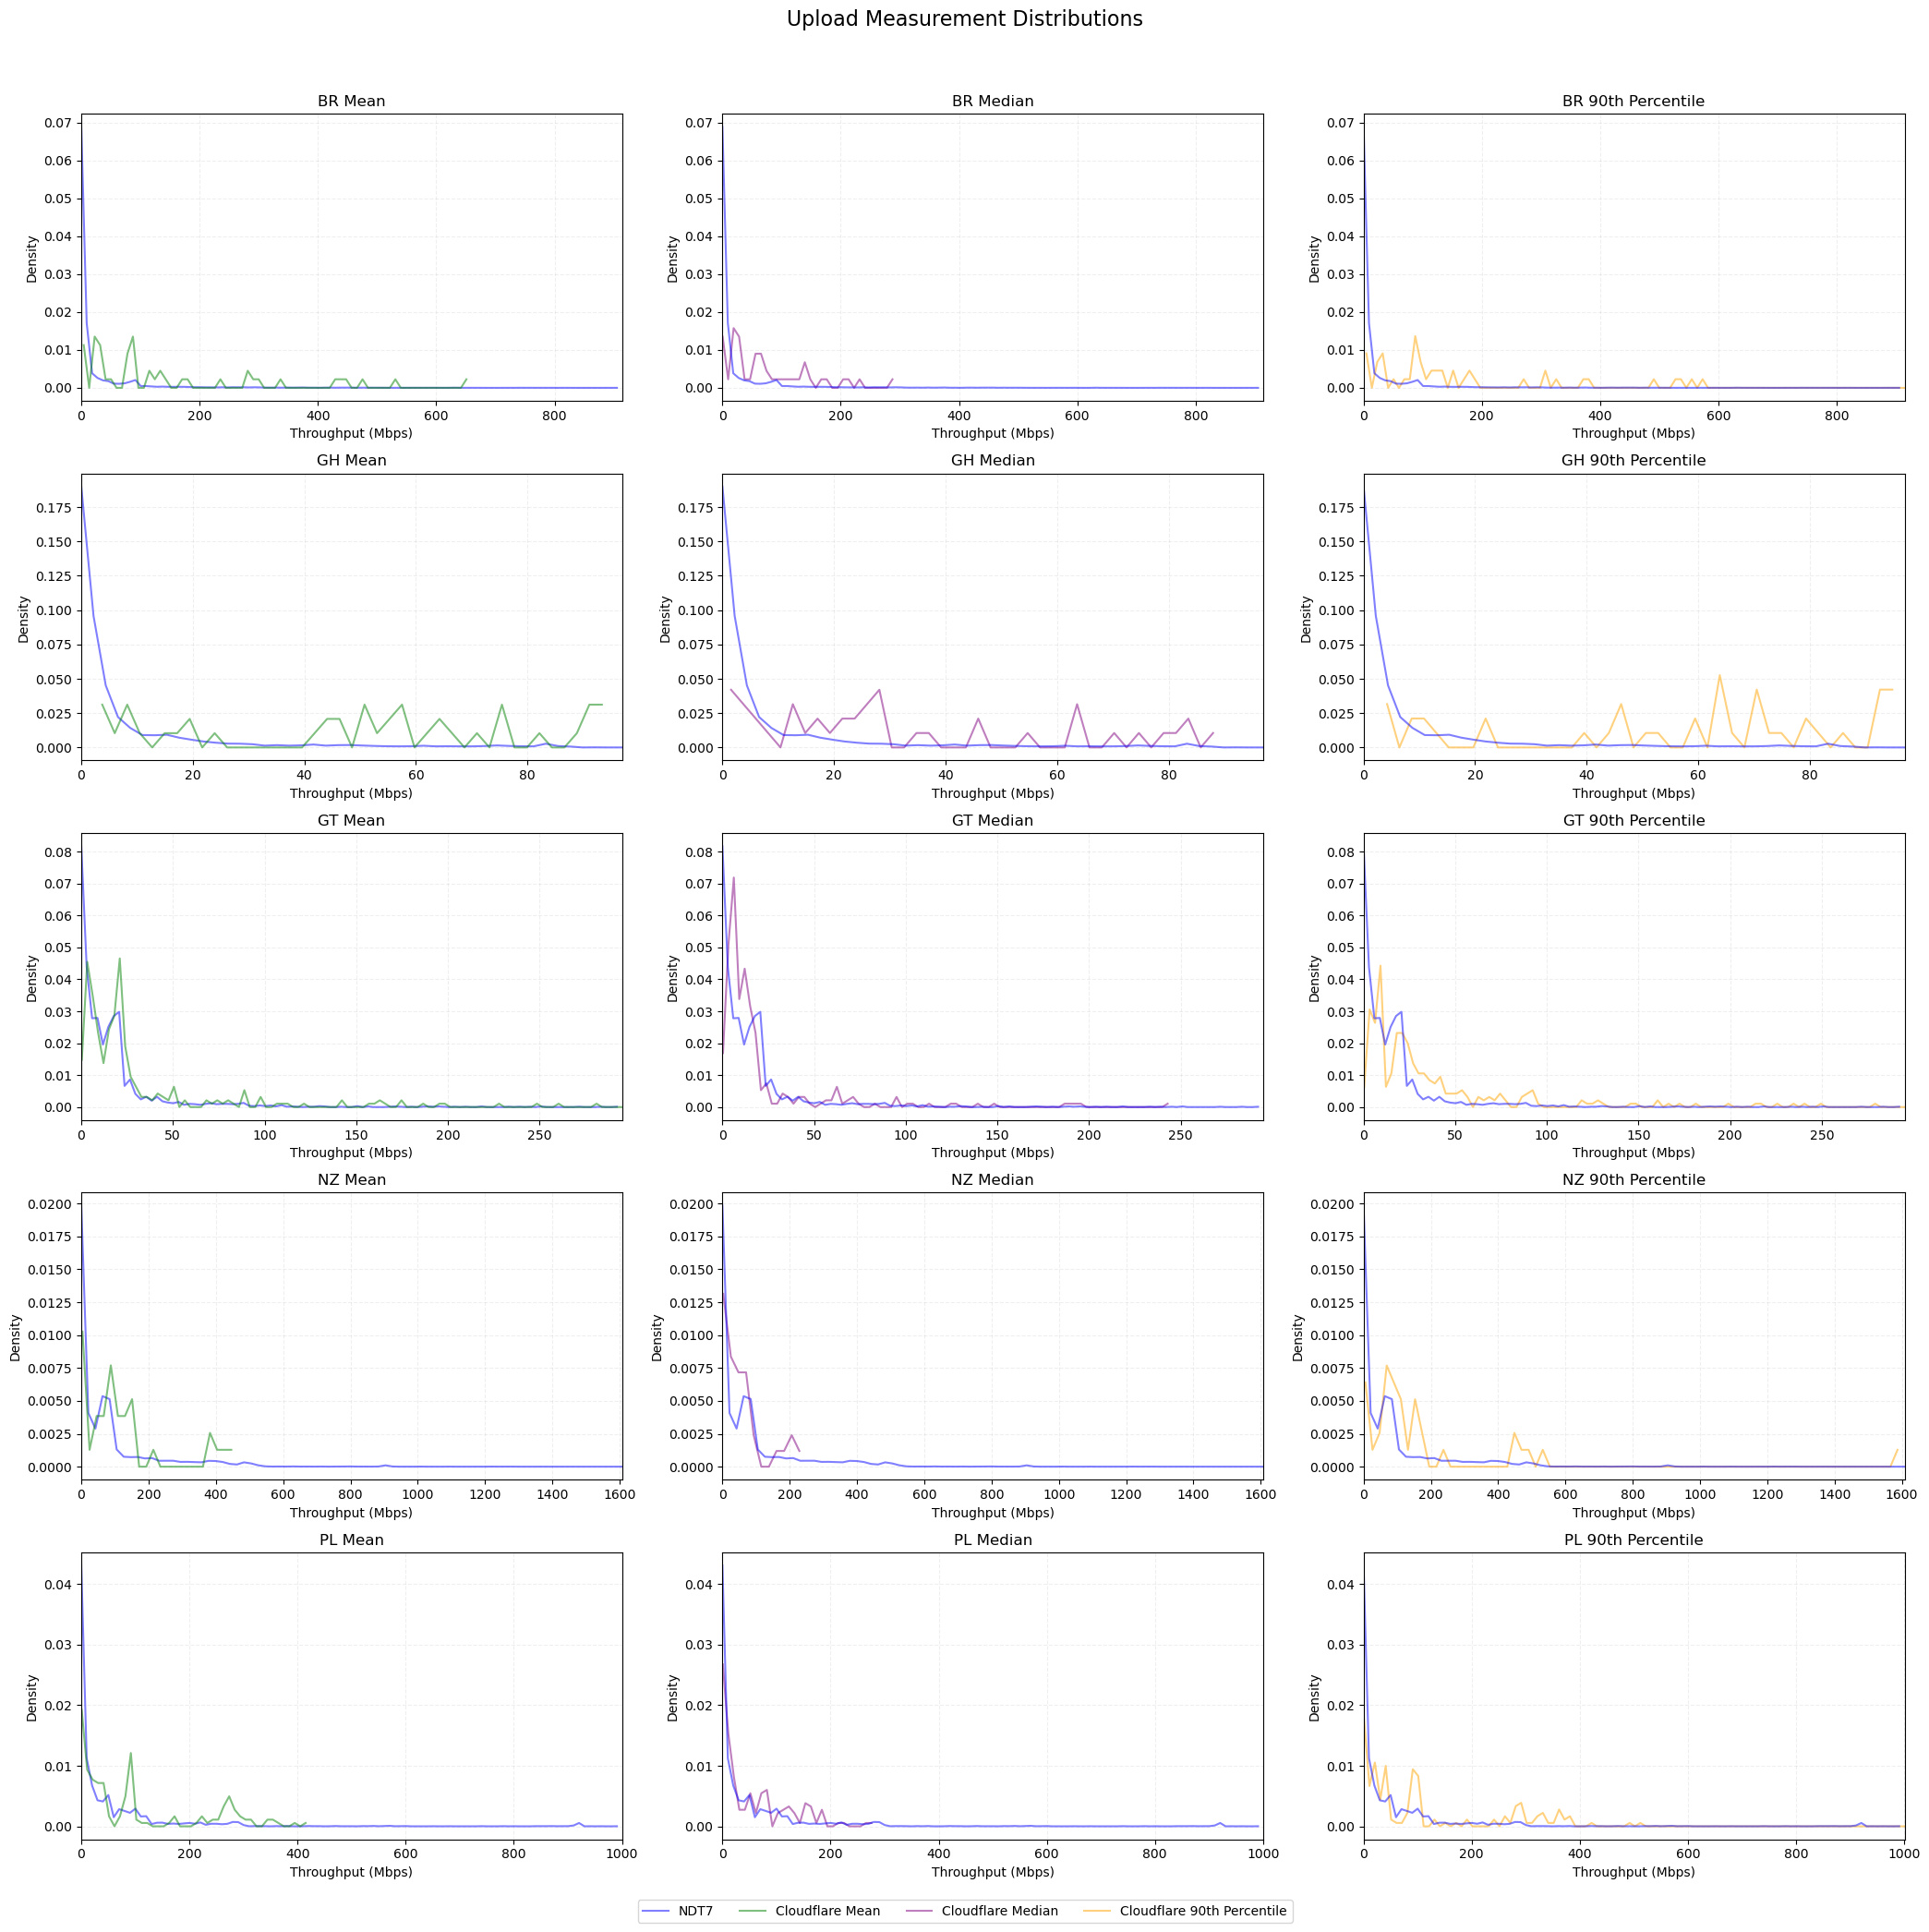

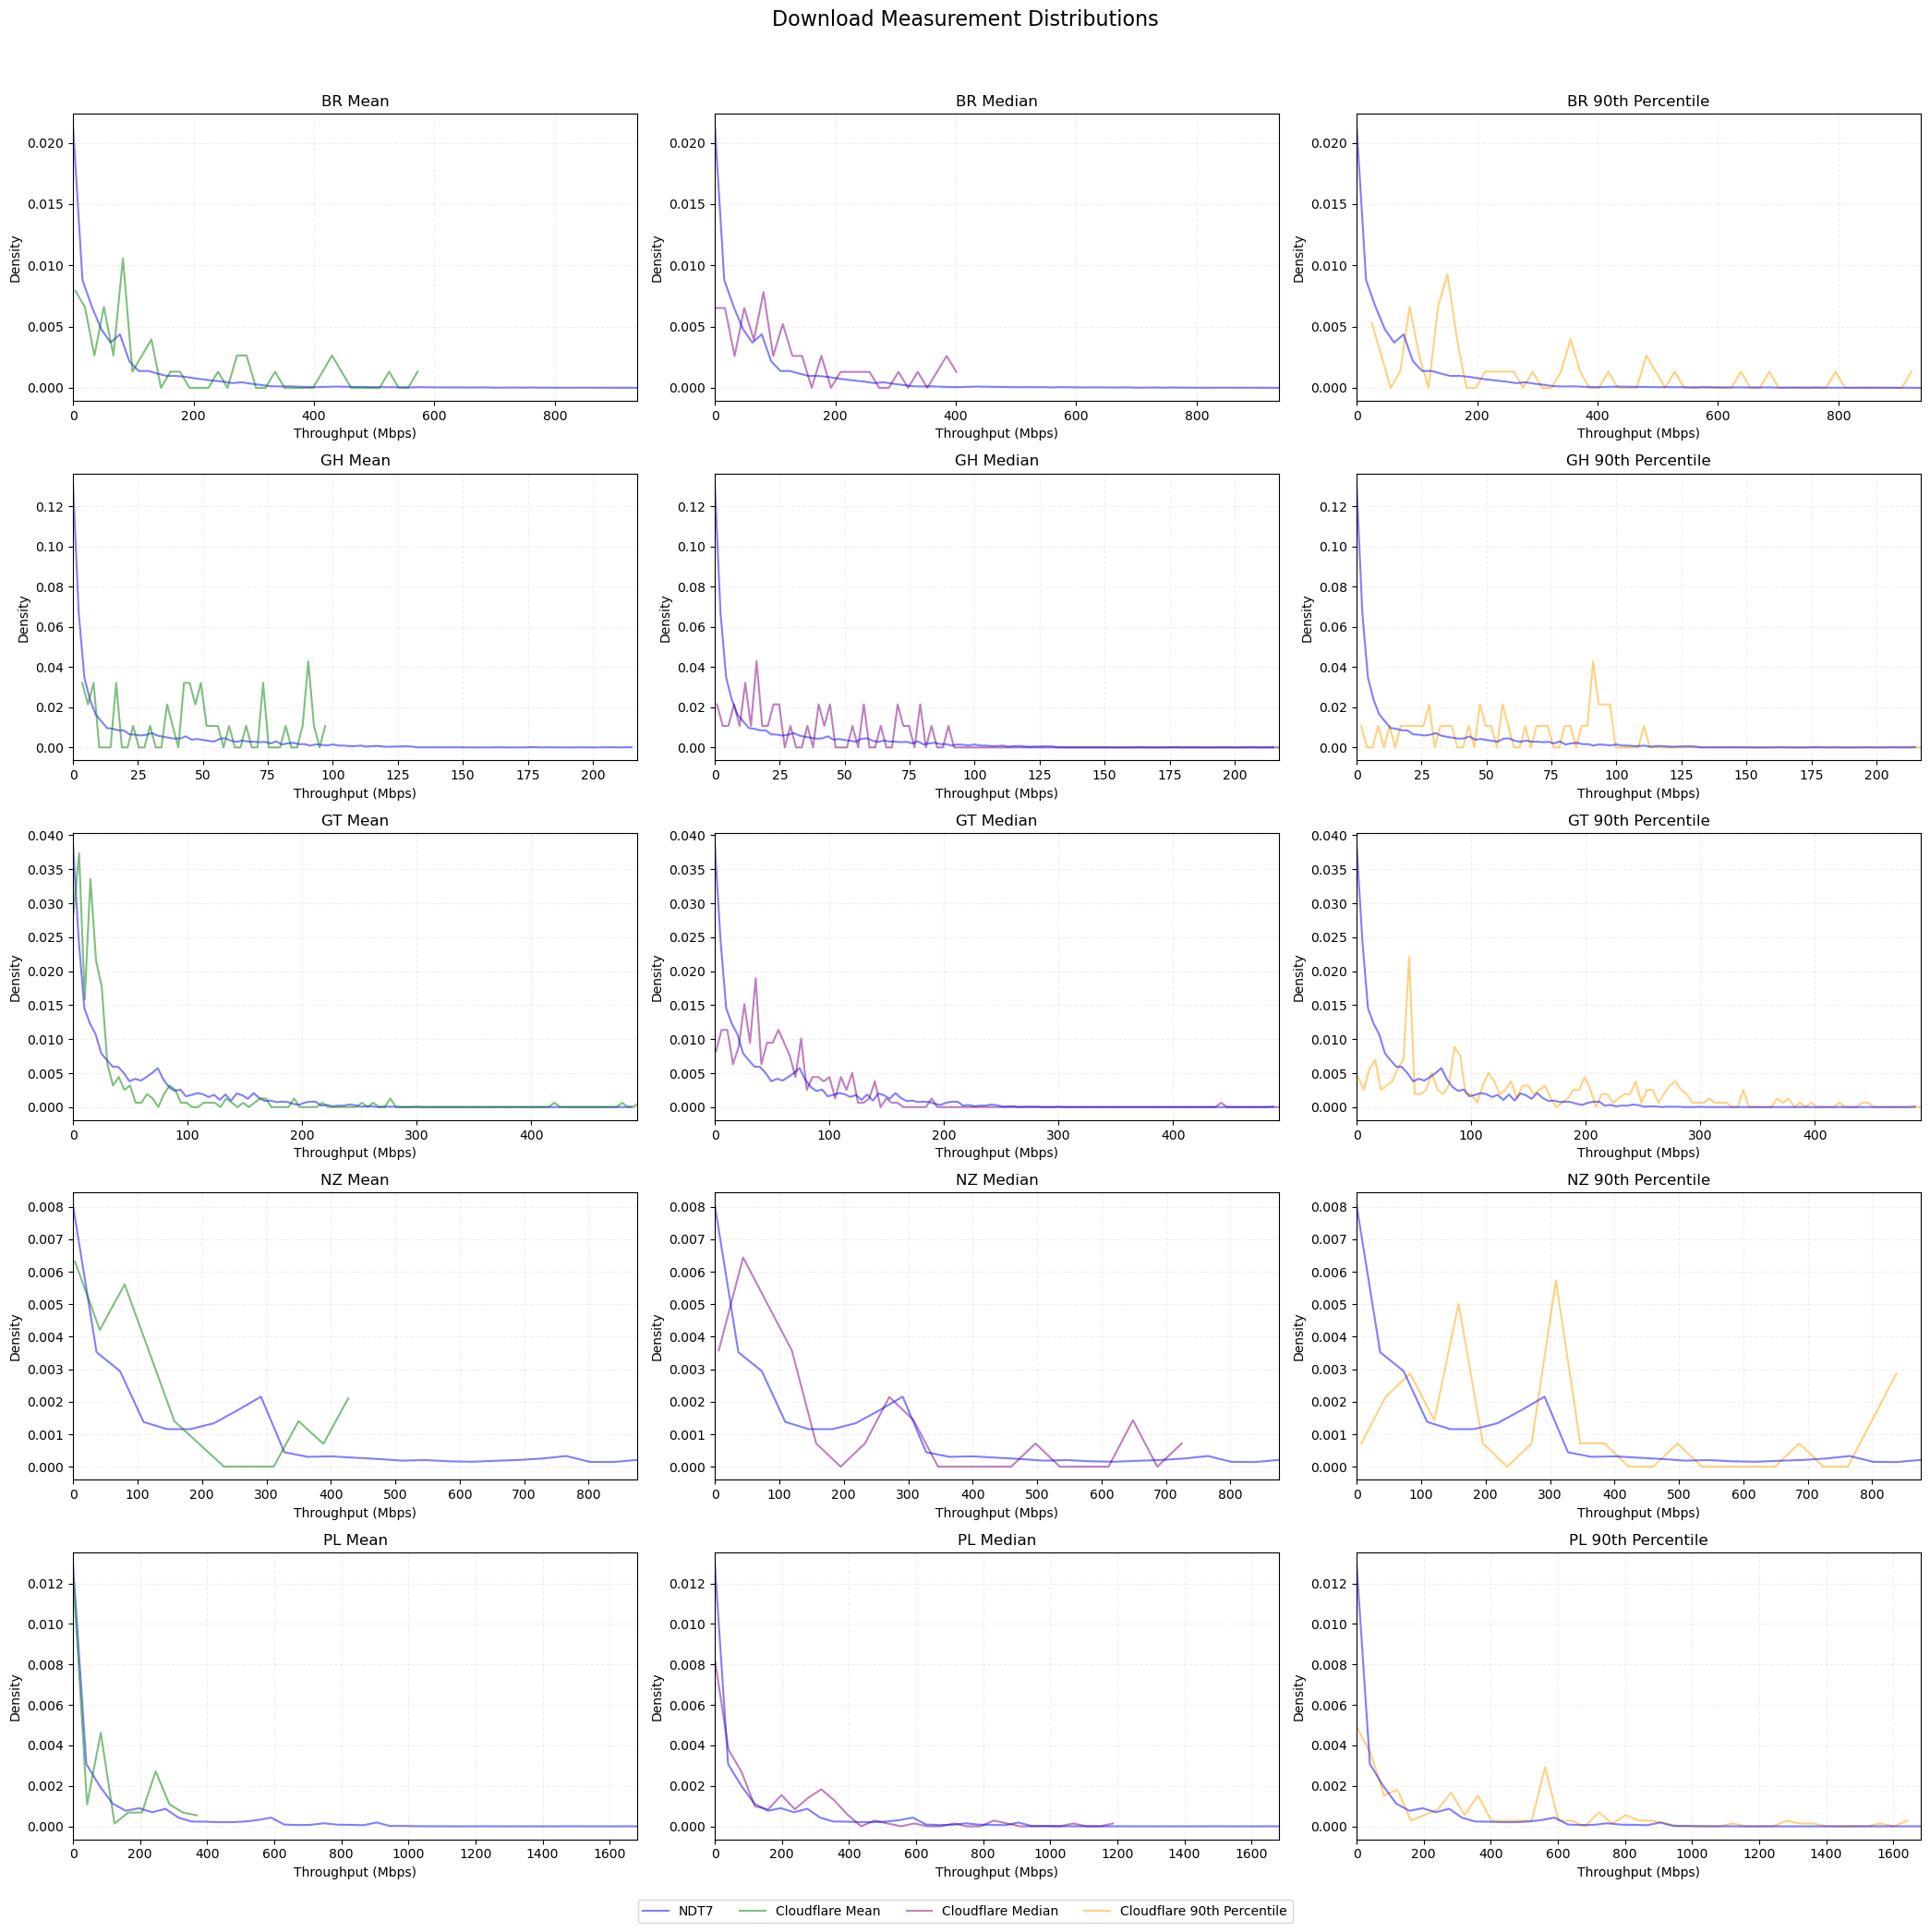

In [20]:
plot_throughputs_upload()
plot_throughputs_download()